## Import libraries and data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from scipy.stats import jarque_bera
from statsmodels.tsa.stattools import adfuller, kpss
#from statsmodels.tsa.stattools import pperron
from hurst import compute_Hc
import seaborn as sns
import arch
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import numpy as np 
from sklearn.tree import DecisionTreeRegressor

In [2]:
raw = pd.read_excel('Dataset.xlsx')

In [3]:
print('The data include',len(raw), 'daily observations.')

The data include 7815 daily observations.


In [4]:
raw['vix_return'] = raw['vix_first_difference'] / raw['vix']
raw['vix_return_lag'] = raw['vix_return'].shift(1)

In [5]:
raw['sp_volume_first_difference'] = raw['sp_volume'].diff()
raw['sp_volume_change'] = raw['sp_volume_first_difference']/raw['sp_volume']
raw['sp_volume_change_lag'] = raw['sp_volume_change'].shift(1)

In [6]:
raw['dxy_return'] = raw['dxy_first_difference']/ raw['dxy']
raw['dxy_return_lag'] = raw['dxy_return'].shift(1)

In [7]:
raw['wti_future_first_difference'] = raw['wti_future'].diff()
raw['wti_future_return'] = raw['wti_future_first_difference']/raw['wti_future']
raw['wti_future_return_lag'] = raw['wti_future_return'].shift(1)

In [8]:
raw['ust_10y_per_change'] = raw['ust_10y_first_difference'] / raw['ust_10y']
raw['ust_10y_per_change_lag'] = raw['ust_10y_per_change'].shift(1)

In [9]:
raw.columns

Index(['Date', 'vix', 'vix_log', 'vix_first_difference', 'sp', 'sp_volume',
       'sp_return', 'ust_10y', 'ust_10y_first_difference', 'dxy',
       'dxy_first_difference', 'wti_future', 'vix_lag', 'vix_log_lag',
       'vix_first_difference_lag', 'sp_lag', 'sp_volume_lag', 'sp_return_lag',
       'ust_10y_lag', 'ust_10y_first_difference_lag', 'dxy_lag',
       'dxy_first_difference_lag', 'wti_future_lag', 'vix_return',
       'vix_return_lag', 'sp_volume_first_difference', 'sp_volume_change',
       'sp_volume_change_lag', 'dxy_return', 'dxy_return_lag',
       'wti_future_first_difference', 'wti_future_return',
       'wti_future_return_lag', 'ust_10y_per_change',
       'ust_10y_per_change_lag'],
      dtype='object')

In [10]:
raw = raw.iloc[2:].reset_index(drop=True)

In [11]:
raw.head()

,Date,vix,vix_log,vix_first_difference,sp,sp_volume,sp_return,ust_10y,ust_10y_first_difference,dxy,...,sp_volume_first_difference,sp_volume_change,sp_volume_change_lag,dxy_return,dxy_return_lag,wti_future_first_difference,wti_future_return,wti_future_return_lag,ust_10y_per_change,ust_10y_per_change_lag
0,1993-01-06,13.37,2.593013,0.02,434.52,218849300,0.000414,6.63,0.02,93.07,...,51006200.0,0.233065,0.166105,0.004620,-0.008851,NaN,NaN,NaN,0.003017,0.001513
1,1993-01-07,14.72,2.689207,1.35,430.73,231186700,-0.008722,6.76,0.13,93.17,...,12337400.0,0.053366,0.233065,0.001073,0.004620,NaN,NaN,NaN,0.019231,0.003017
2,1993-01-08,13.77,2.622492,-0.95,429.05,191369800,-0.003900,6.75,-0.01,93.45,...,-39816900.0,-0.208063,0.053366,0.002996,0.001073,NaN,NaN,NaN,-0.001481,0.019231
3,1993-01-11,12.86,2.554122,-0.91,430.95,151430800,0.004428,6.71,-0.04,92.69,...,-39939000.0,-0.263744,-0.208063,-0.008199,0.002996,NaN,NaN,NaN,-0.005961,-0.001481
4,1993-01-12,12.78,2.547881,-0.08,431.04,169692300,0.000209,6.72,0.01,92.89,...,18261500.0,0.107615,-0.263744,0.002153,-0.008199,NaN,NaN,NaN,0.001488,-0.005961


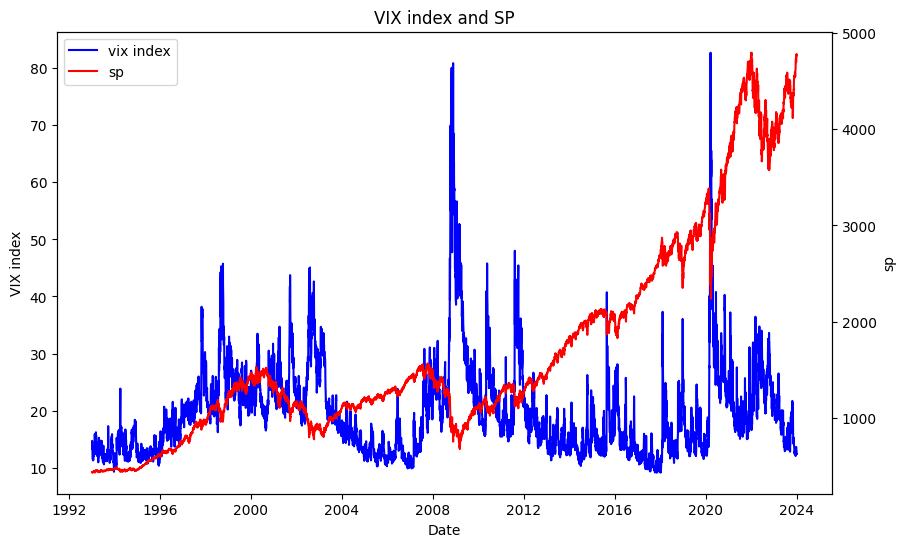

In [12]:
# Plotting with a secondary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot lines for Variable1 and Variable2 on the primary y-axis
ax1.plot(raw['Date'], raw['vix'], label='vix index', color='blue')

# Set labels for the primary y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('VIX index', color='black')
ax1.tick_params('y', colors='black')

# Create a secondary y-axis for Variable3
ax2 = ax1.twinx()
ax2.plot(raw['Date'], raw['sp'], label='sp', color='red')
ax2.set_ylabel('sp', color='black')
ax2.tick_params('y', colors='black')

# Adding legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Display the plot
plt.title('VIX index and SP')
plt.show()

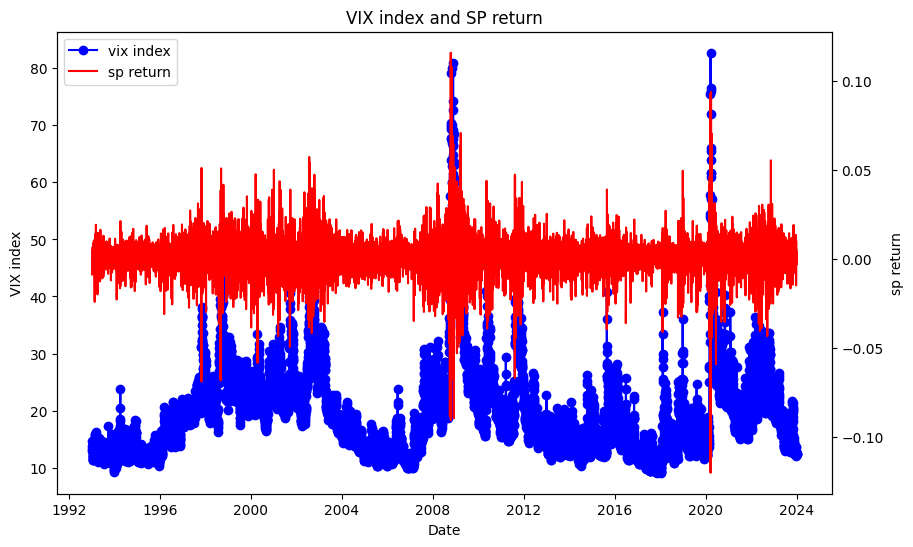

In [13]:
# Plotting with a secondary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot lines for Variable1 and Variable2 on the primary y-axis
ax1.plot(raw['Date'], raw['vix'], label='vix index', marker = 'o', color='blue')

# Set labels for the primary y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('VIX index', color='black')
ax1.tick_params('y', colors='black')

# Create a secondary y-axis for Variable3
ax2 = ax1.twinx()
ax2.plot(raw['Date'], raw['sp_return'], label='sp return', color='red')
ax2.set_ylabel('sp return', color='black')
ax2.tick_params('y', colors='black')

# Adding legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Display the plot
plt.title('VIX index and SP return')
plt.show()

## Descriptive analysis of the VIX index

In [14]:
vix_1 = raw[['Date','vix']][:4000]
vix_2 = raw[['Date','vix']][4000:]
vix_full = raw[['Date','vix']]

In [15]:
dfs = [vix_1, vix_2, vix_full]
col_names = ['first_half','second_half','full_sample']
describe = pd.DataFrame()

In [16]:
for i in range(len(dfs)):
    df = dfs[i]
    col_name = col_names[i]
    describe_1 = pd.DataFrame(df['vix'].describe())
    describe_1 = describe_1.rename(columns={'vix':col_name})
    describe = pd.concat([describe,describe_1], axis=1)

describe

,first_half,second_half,full_sample
count,4000.000000,3813.000000,7813.000000
mean,19.607660,19.684915,19.645363
std,7.832308,8.456093,8.142276
min,9.310000,9.140000,9.140000
25%,13.420000,13.850000,13.670000
50%,18.550000,17.340000,17.840000
75%,23.462500,22.790000,23.190000
max,80.860000,82.690000,82.690000


In [17]:
describe.loc['skew'] = [skew(df['vix']) for df in dfs] 
describe.loc['kurtosis'] = [kurtosis(df['vix']) for df in dfs] 
# this outputs p-value of the jarque-bera test, p<0.05 means the distribution is not normal
describe.loc['Jarque-Bera'] = [jarque_bera(df['vix'])[1] for df in dfs] 
describe.loc['ADF'] = [adfuller(df['vix'], autolag='AIC')[1] for df in dfs] 
describe.loc['KPSS'] = [kpss(df['vix'])[1] for df in dfs] 
describe.loc['R/S'] = [compute_Hc(df['vix'], kind='price', simplified = False)[0] for df in dfs] 

C:\Users\User\AppData\Local\Temp\ipykernel_6420\10185607.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  describe.loc['KPSS'] = [kpss(df['vix'])[1] for df in dfs]
C:\Users\User\AppData\Local\Temp\ipykernel_6420\10185607.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  describe.loc['KPSS'] = [kpss(df['vix'])[1] for df in dfs]


In [18]:
describe

,first_half,second_half,full_sample
count,4000.000000,3.813000e+03,7813.000000
mean,19.607660,1.968491e+01,19.645363
std,7.832308,8.456093e+00,8.142276
min,9.310000,9.140000e+00,9.140000
25%,13.420000,1.385000e+01,13.670000
50%,18.550000,1.734000e+01,17.840000
75%,23.462500,2.279000e+01,23.190000
max,80.860000,8.269000e+01,82.690000
skew,2.109578,2.131893e+00,2.127433
kurtosis,9.094517,6.942416e+00,7.948403


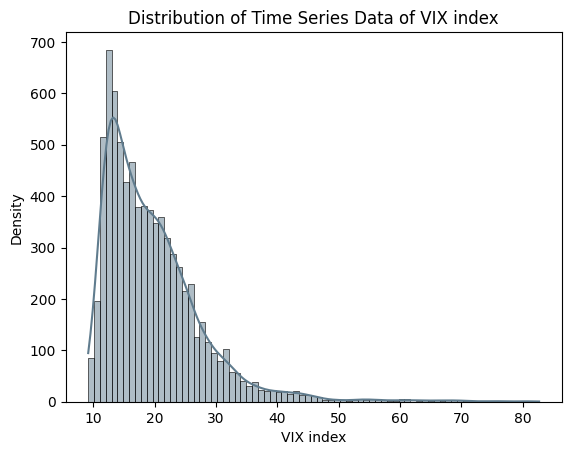

In [19]:
sns.histplot(vix_full['vix'], bins='auto', kde=True, color='#607c8e')
plt.title('Distribution of Time Series Data of VIX index')
plt.xlabel('VIX index')
plt.ylabel('Density')
plt.show()

### Analysis of the descriptive stats
All 3 periods have positive skew and large excess kurtosis <br>

Jarque-Bera test p value all < 0.05, this means the series is not normally distributed <br>

ADF test strongly rejects null hypothesis for second half and full sample, cannot reject for first half. This means the first half is non-stationary and second half is stationary. This reflects regime shift in VIX index <br>

KPSS test rejects null for first half and second half, fails to reject null for full sample. This means first half and second half are both not trend stationary whereas the full sample is trend stationary. Both tests conclude that the full sample is trend stationary and first half is not stationary. They do not agree regarding wether the second half is stationary <br>

R/S test results are all < 0.5. There is not enough evidence for long memory

## Describe log VIX index

In [20]:
vixlog_1 = raw[['Date','vix_log']][:4000]
vixlog_2 = raw[['Date','vix_log']][4000:]
vixlog_full = raw[['Date','vix_log']]

In [21]:
logdfs = [vixlog_1, vixlog_2, vixlog_full]
col_names = ['first_half','second_half','full_sample']
describelog = pd.DataFrame()

In [22]:
for i in range(len(logdfs)):
    logdf = logdfs[i]
    col_name = col_names[i]
    describe_1 = pd.DataFrame(logdf['vix_log'].describe())
    describe_1 = describe_1.rename(columns={'vix_log':col_name})
    describelog = pd.concat([describelog,describe_1], axis=1)

describelog

,first_half,second_half,full_sample
count,4000.000000,3813.000000,7813.000000
mean,2.910444,2.908377,2.909435
std,0.351585,0.361230,0.356303
min,2.231089,2.212660,2.212660
25%,2.596746,2.628285,2.615204
50%,2.920470,2.853016,2.881443
75%,3.155403,3.126322,3.143721
max,4.392719,4.415099,4.415099


In [23]:
describelog.loc['skew'] = [skew(logdf['vix_log']) for logdf in logdfs] 
describelog.loc['kurtosis'] = [kurtosis(logdf['vix_log']) for logdf in logdfs] 
describelog.loc['Jarque-Bera'] = [jarque_bera(logdf['vix_log'])[1] for logdf in logdfs] 
describelog.loc['ADF'] = [adfuller(logdf['vix_log'],autolag='AIC')[1] for logdf in logdfs] 
describelog.loc['KPSS'] = [kpss(logdf['vix_log'])[1] for logdf in logdfs] 
describelog.loc['R/S'] = [compute_Hc(logdf['vix_log'], kind='price', simplified = False)[0] for logdf in logdfs]  

C:\Users\User\AppData\Local\Temp\ipykernel_6420\127392688.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  describelog.loc['KPSS'] = [kpss(logdf['vix_log'])[1] for logdf in logdfs]
C:\Users\User\AppData\Local\Temp\ipykernel_6420\127392688.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  describelog.loc['KPSS'] = [kpss(logdf['vix_log'])[1] for logdf in logdfs]


In [24]:
describelog

,first_half,second_half,full_sample
count,4.000000e+03,3.813000e+03,7.813000e+03
mean,2.910444e+00,2.908377e+00,2.909435e+00
std,3.515852e-01,3.612299e-01,3.563034e-01
min,2.231089e+00,2.212660e+00,2.212660e+00
25%,2.596746e+00,2.628285e+00,2.615204e+00
50%,2.920470e+00,2.853016e+00,2.881443e+00
75%,3.155403e+00,3.126322e+00,3.143721e+00
max,4.392719e+00,4.415099e+00,4.415099e+00
skew,4.902140e-01,7.557447e-01,6.251174e-01
kurtosis,1.134809e-01,4.986791e-01,3.124741e-01


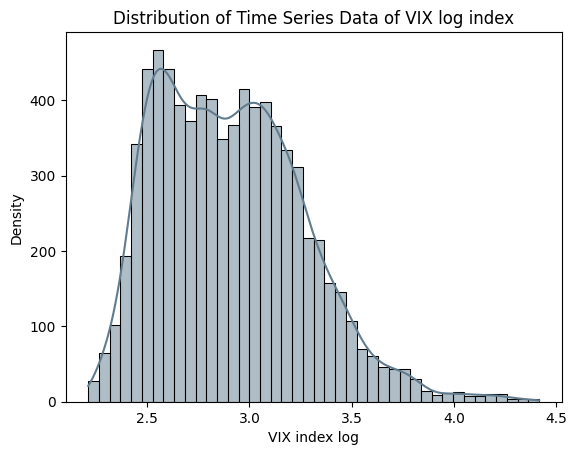

In [25]:
sns.histplot(vixlog_full['vix_log'], bins='auto', kde=True, color='#607c8e')
plt.title('Distribution of Time Series Data of VIX log index')
plt.xlabel('VIX index log')
plt.ylabel('Density')
plt.show()

### Analysis of the descriptive stats
All 3 periods have small positive skew and excess kurtosis <br>

Jarque-Bera test p value all < 0.05, this means the series is not normally distributed <br>

ADF test strongly rejects null hypothesis for second half and full sample, cannot reject for first half. This means the first half is non-stationary and second half is stationary. This reflects regime shift in VIX index. Same as the vix series. <br>

KPSS test rejects null for all 3 periods at alpha=0.05. This means all 3 periods are not trend stationary.Both tests conclude that first half is not stationary. They do not agree regarding wether the second half and full sample are stationary <br>

R/S test results are all < 0.5. There is not enough evidence for long memory.

## Describe first difference of vix index

In [26]:
vixdiff_1 = raw[['Date','vix_first_difference']][:4000]
vixdiff_2 = raw[['Date','vix_first_difference']][4000:]
vixdiff_full = raw[['Date','vix_first_difference']]

In [27]:
diffdfs = [vixdiff_1, vixdiff_2, vixdiff_full]
col_names = ['first_half','second_half','full_sample']
describediff = pd.DataFrame()

In [28]:
for i in range(len(diffdfs)):
    diffdf = diffdfs[i]
    col_name = col_names[i]
    describe_1 = pd.DataFrame(diffdf['vix_first_difference'].describe())
    describe_1 = describe_1.rename(columns={'vix_first_difference':col_name})
    describediff = pd.concat([describediff,describe_1], axis=1)

describediff

,first_half,second_half,full_sample
count,4000.000000,3813.000000,7813.000000
mean,0.016877,-0.017941,-0.000115
std,1.442091,1.880973,1.670728
min,-17.360000,-17.640000,-17.640000
25%,-0.592500,-0.780000,-0.680000
50%,-0.030000,-0.110000,-0.070000
75%,0.570000,0.570000,0.570000
max,16.540000,24.860000,24.860000


In [29]:
describediff.loc['skew'] = [skew(diffdf['vix_first_difference']) for diffdf in diffdfs] 
describediff.loc['kurtosis'] = [kurtosis(diffdf['vix_first_difference']) for diffdf in diffdfs] 
describediff.loc['Jarque-Bera'] = [jarque_bera(diffdf['vix_first_difference'])[1] for diffdf in diffdfs] 
describediff.loc['ADF'] = [adfuller(diffdf['vix_first_difference'], autolag = 'AIC')[1] for diffdf in diffdfs] 
describediff.loc['KPSS'] = [kpss(diffdf['vix_first_difference'])[1] for diffdf in diffdfs] 
# describediff.loc['R/S'] = [compute_Hc(diffdf['vix_first_difference'], kind='price', simplified = False)[0] for diffdf in diffdfs]

C:\Users\User\AppData\Local\Temp\ipykernel_6420\1366341660.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  describediff.loc['KPSS'] = [kpss(diffdf['vix_first_difference'])[1] for diffdf in diffdfs]
C:\Users\User\AppData\Local\Temp\ipykernel_6420\1366341660.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  describediff.loc['KPSS'] = [kpss(diffdf['vix_first_difference'])[1] for diffdf in diffdfs]
C:\Users\User\AppData\Local\Temp\ipykernel_6420\1366341660.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  describediff.loc['KPSS'] = [kpss(diffdf['vix_first_difference'])[1] for diffdf in diffdfs]


In [30]:
describediff

,first_half,second_half,full_sample
count,4.000000e+03,3.813000e+03,7.813000e+03
mean,1.687750e-02,-1.794125e-02,-1.151926e-04
std,1.442091e+00,1.880973e+00,1.670728e+00
min,-1.736000e+01,-1.764000e+01,-1.764000e+01
25%,-5.925000e-01,-7.800000e-01,-6.800000e-01
50%,-3.000000e-02,-1.100000e-01,-7.000000e-02
75%,5.700000e-01,5.700000e-01,5.700000e-01
max,1.654000e+01,2.486000e+01,2.486000e+01
skew,2.906080e-01,1.992689e+00,1.474995e+00
kurtosis,2.219017e+01,2.616802e+01,2.696580e+01


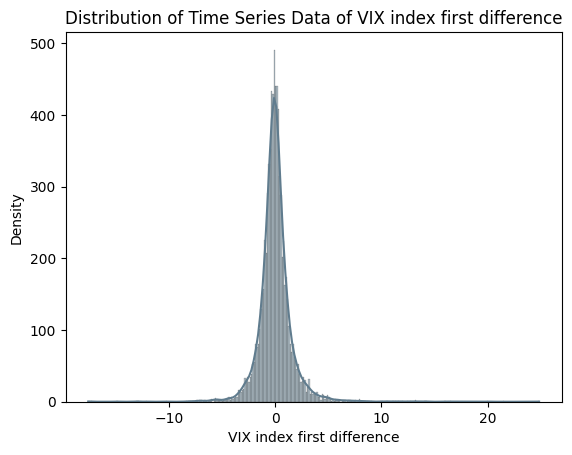

In [31]:
sns.histplot(vixdiff_full['vix_first_difference'], bins='auto', kde=True, color='#607c8e')
plt.title('Distribution of Time Series Data of VIX index first difference')
plt.xlabel('VIX index first difference')
plt.ylabel('Density')
plt.show()

### Analysis of the descriptive stats
All 3 periods have small positive skew and excess kurtosis <br>

Jarque-Bera test p value all < 0.05, this means the series is not normally distributed <br>

ADF test strongly rejects null hypothesis for all 3 periods. This means stationarity in all 3 periods. <br>

KPSS test rejects null for all 3 periods at alpha=0.05. This means all 3 periods are not trend stationary. ADF and KPSS tests contradict each other. inconclusive results 

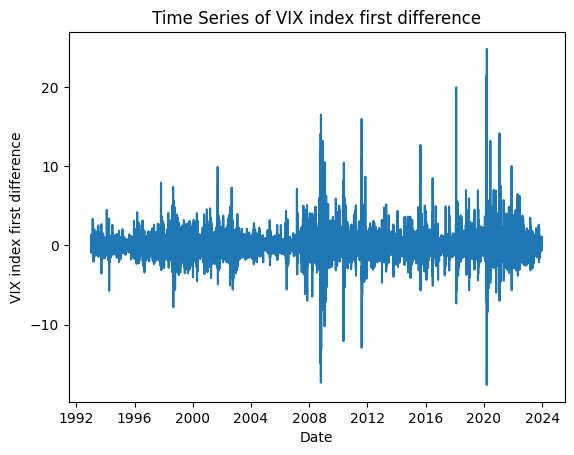

In [32]:
plt.plot(vixdiff_full['Date'], vixdiff_full['vix_first_difference'])
plt.title('Time Series of VIX index first difference')
plt.xlabel('Date')
plt.ylabel('VIX index first difference')
plt.show()
# the plot shows volatility clustering

### Percentage change in VIX

In [33]:
vixret_1 = raw[['Date','vix_return']][:4000]
vixret_2 = raw[['Date','vix_return']][4000:]
vixret_full = raw[['Date','vix_return']]

In [34]:
retdfs = [vixret_1, vixret_2, vixret_full]
col_names = ['first_half','second_half','full_sample']
describeret = pd.DataFrame()

In [35]:
for i in range(len(retdfs)):
    retdf = retdfs[i]
    col_name = col_names[i]
    describe_1 = pd.DataFrame(retdf['vix_return'].describe())
    describe_1 = describe_1.rename(columns={'vix_return':col_name})
    describeret = pd.concat([describeret,describe_1], axis=1)

describeret

,first_half,second_half,full_sample
count,4000.000000,3813.000000,7813.000000
mean,-0.001241,-0.003290,-0.002241
std,0.057906,0.073480,0.065972
min,-0.349686,-0.419903,-0.419903
25%,-0.034579,-0.044361,-0.039258
50%,-0.001931,-0.007080,-0.004127
75%,0.031414,0.033457,0.032152
max,0.391043,0.536174,0.536174


In [36]:
describeret.loc['skew'] = [skew(retdf['vix_return']) for retdf in retdfs] 
describeret.loc['kurtosis'] = [kurtosis(retdf['vix_return']) for retdf in retdfs] 
describeret.loc['Jarque-Bera'] = [jarque_bera(retdf['vix_return'])[1] for retdf in retdfs] 
describeret.loc['ADF'] = [adfuller(retdf['vix_return'], autolag = 'AIC')[1] for retdf in retdfs] 
describeret.loc['KPSS'] = [kpss(retdf['vix_return'])[1] for retdf in retdfs] 

C:\Users\User\AppData\Local\Temp\ipykernel_6420\2771477014.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  describeret.loc['KPSS'] = [kpss(retdf['vix_return'])[1] for retdf in retdfs]
C:\Users\User\AppData\Local\Temp\ipykernel_6420\2771477014.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  describeret.loc['KPSS'] = [kpss(retdf['vix_return'])[1] for retdf in retdfs]


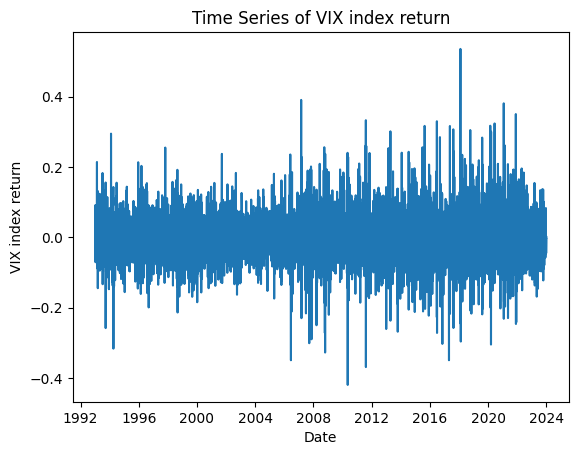

In [37]:
plt.plot(raw['Date'], raw['vix_return'])
plt.title('Time Series of VIX index return')
plt.xlabel('Date')
plt.ylabel('VIX index return')
plt.show()

In [38]:
describediff

,first_half,second_half,full_sample
count,4.000000e+03,3.813000e+03,7.813000e+03
mean,1.687750e-02,-1.794125e-02,-1.151926e-04
std,1.442091e+00,1.880973e+00,1.670728e+00
min,-1.736000e+01,-1.764000e+01,-1.764000e+01
25%,-5.925000e-01,-7.800000e-01,-6.800000e-01
50%,-3.000000e-02,-1.100000e-01,-7.000000e-02
75%,5.700000e-01,5.700000e-01,5.700000e-01
max,1.654000e+01,2.486000e+01,2.486000e+01
skew,2.906080e-01,1.992689e+00,1.474995e+00
kurtosis,2.219017e+01,2.616802e+01,2.696580e+01


## Predictive Models

### ACF and PACF plots

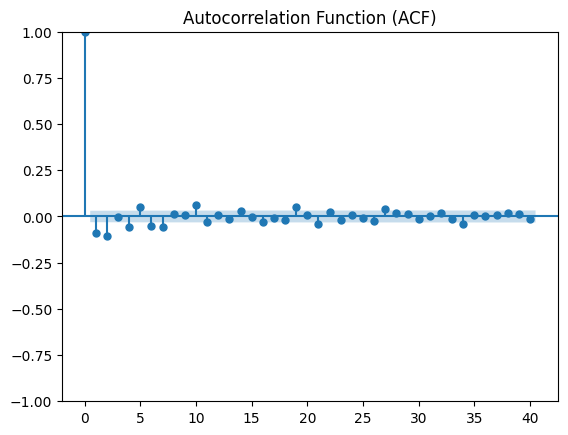

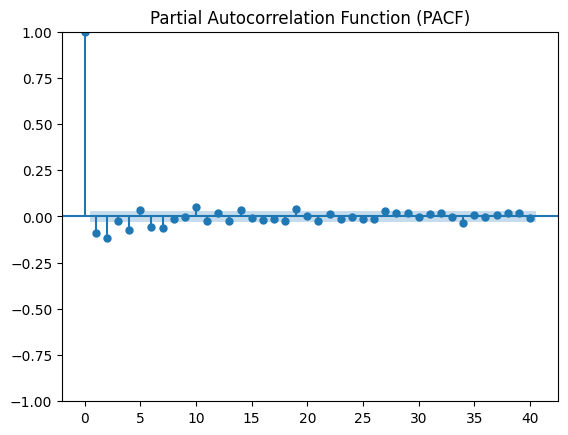

In [39]:
# first half
# Plot ACF
plot_acf(vixdiff_1['vix_first_difference'], lags=40, title='Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plot_pacf(vixdiff_1['vix_first_difference'], lags=40, title='Partial Autocorrelation Function (PACF)')
plt.show()

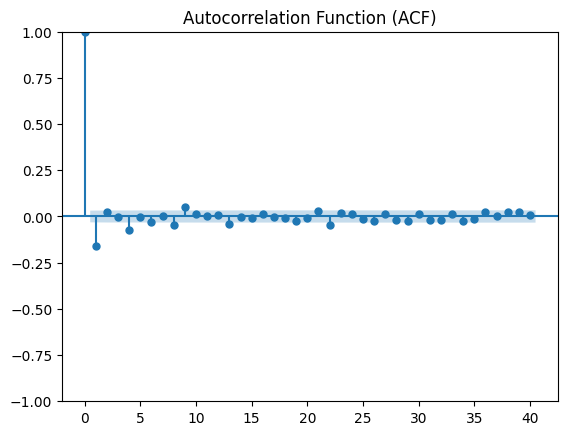

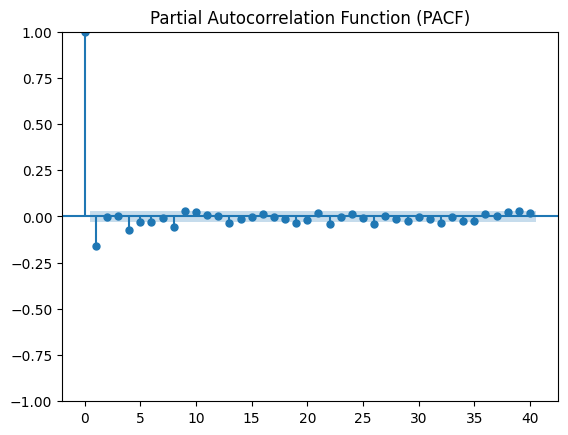

In [40]:
# second half
# Plot ACF
plot_acf(vixdiff_2['vix_first_difference'], lags=40, title='Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plot_pacf(vixdiff_2['vix_first_difference'], lags=40, title='Partial Autocorrelation Function (PACF)')
plt.show()

# 1,4,8 for both ACF and PACF are statistically significant

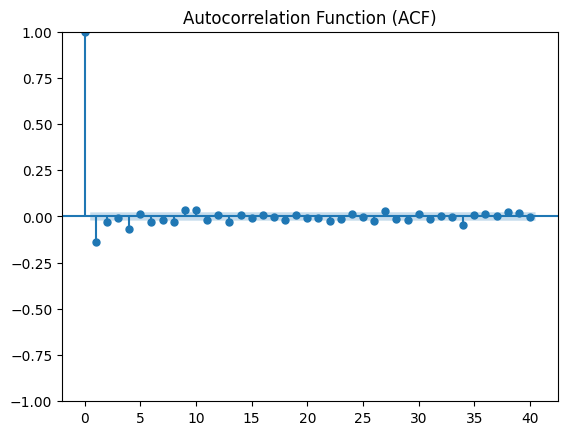

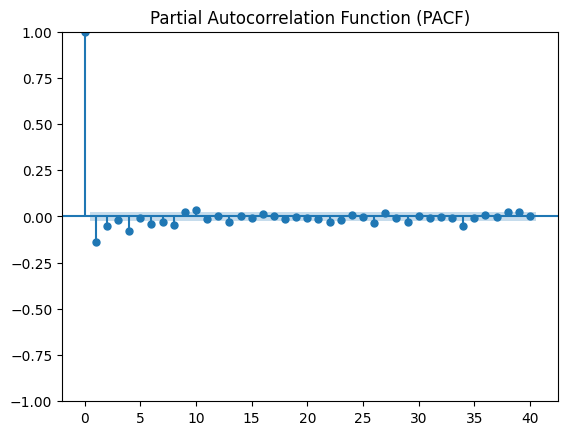

In [41]:
# full history
# Plot ACF
plot_acf(vixdiff_full['vix_first_difference'], lags=40, title='Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plot_pacf(vixdiff_full['vix_first_difference'], lags=40, title='Partial Autocorrelation Function (PACF)')
plt.show()

Index(['Date', 'vix', 'vix_log', 'vix_first_difference', 'sp', 'sp_volume',
       'sp_return', 'ust_10y', 'ust_10y_first_difference', 'dxy',
       'dxy_first_difference', 'wti_future', 'vix_lag', 'vix_log_lag',
       'vix_first_difference_lag', 'sp_lag', 'sp_volume_lag', 'sp_return_lag',
       'ust_10y_lag', 'ust_10y_first_difference_lag', 'dxy_lag',
       'dxy_first_difference_lag', 'wti_future_lag', 'vix_return',
       'vix_return_lag', 'sp_volume_first_difference', 'sp_volume_change',
       'sp_volume_change_lag', 'dxy_return', 'dxy_return_lag',
       'wti_future_first_difference', 'wti_future_return',
       'wti_future_return_lag', 'ust_10y_per_change',
       'ust_10y_per_change_lag'],
      dtype='object')

### Exogeneous Variables

In [42]:
x_variables = ['vix_return_lag','sp_return_lag', 'sp_volume_change_lag','ust_10y_per_change_lag',\
               'dxy_return_lag']
X = raw[x_variables][:6000]
y = raw['vix_return'][:6000]

### Naive Model 1 - both first and second half

In [43]:
# split in chronological order
X_train = X[:4500]
X_test = X[4500:]
y_train = y[:4500]
y_test = y[4500:]

In [44]:
# naive prediction model
y_pred_naive1 = y_test.shift(1)[1:]

In [45]:
y_test[1:]

4501   -0.160533
4502   -0.039357
4503    0.017964
4504    0.109549
4505   -0.054703
          ...   
5995    0.054775
5996    0.072917
5997    0.051266
5998    0.050996
5999    0.080819
Name: vix_return, Length: 1499, dtype: float64

In [46]:
r2_naive1 = r2_score(y_test[1:].reset_index(drop=True), y_pred_naive1)
 
y_pred_naive1 = y_pred_naive1.reset_index(drop=True)

binary_naive1 = np.sum((y_test[1:].reset_index(drop=True) * y_pred_naive1) > 0)/ len(y_test[1:])
mse_naive1 = mean_squared_error(y_test[1:].reset_index(drop=True), y_pred_naive1)

print(f"Mean Squared Error of naive model 1 is: {mse_naive1}")
print(f"R2 error of naive model 1 is: {r2_naive1}")
print(f"Percentage of correct direction predicted is: {binary_naive1}")

Mean Squared Error of naive model 1 is: 0.011752797396336511
R2 error of naive model 1 is: -1.1478752447094998
Percentage of correct direction predicted is: 0.4836557705136758


In [47]:
y_pred_naive1

0      -0.037684
1      -0.160533
2      -0.039357
3       0.017964
4       0.109549
          ...   
1494    0.032689
1495    0.054775
1496    0.072917
1497    0.051266
1498    0.050996
Name: vix_return, Length: 1499, dtype: float64

### Plot naive prediction 1 vs actual y test

In [48]:
actual = raw[4500:][1:1501][['Date','vix']]
actual = actual.reset_index()

In [49]:
data_plot = actual[['Date','vix']]

In [50]:
naive_prediction = (1+y_pred_naive1)*raw[4500:][:1500]['vix'].reset_index(drop=True)

In [51]:
len(naive_prediction)

1500

In [52]:
data_plot['naive_prediction'] = naive_prediction

In [53]:
data_plot

,Date,vix,naive_prediction
0,2010-11-18,18.75,20.94
1,2010-11-19,18.04,15.74
2,2010-11-22,18.37,17.33
3,2010-11-23,20.63,18.70
4,2010-11-24,19.56,22.89
...,...,...,...
1495,2016-10-27,15.36,15.02
1496,2016-10-28,16.19,16.48
1497,2016-10-31,17.06,17.02
1498,2016-11-01,18.56,17.93


Text(0.5, 1.0, 'Naive Prediction')

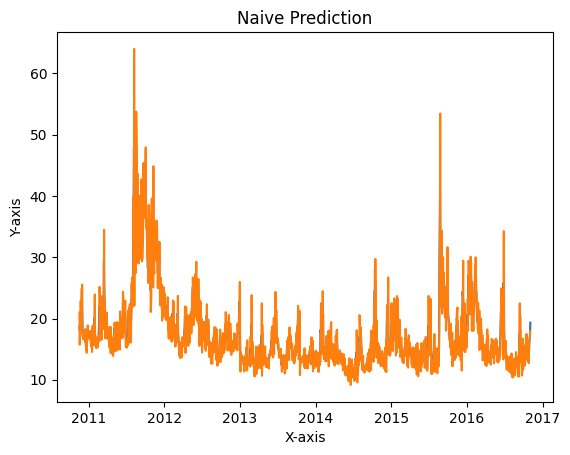

In [54]:
# Plotting the lines
plt.plot(data_plot['Date'], data_plot['vix'], label='actual vix')
plt.plot(data_plot['Date'], data_plot['naive_prediction'], label='naive prediction')

# Adding labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Naive Prediction')

### Naive model second half only

In [55]:
# split in chronological order
X_train2 = X[4000:5500].reset_index(drop=True)
X_test2 = X[5500:].reset_index(drop=True)
y_train2 = y[4000:5500].reset_index(drop=True)
y_test2 = y[5500:].reset_index(drop=True)

In [56]:
# naive prediction model
y_pred_naive2 = y_test2.shift(1)[1:].reset_index(drop=True)

In [57]:
y_pred_naive2

0     -0.041921
1     -0.035517
2      0.019350
3      0.007680
4      0.055838
         ...   
494    0.032689
495    0.054775
496    0.072917
497    0.051266
498    0.050996
Name: vix_return, Length: 499, dtype: float64

In [58]:
y_test2[1:].reset_index(drop=True)

0     -0.035517
1      0.019350
2      0.007680
3      0.055838
4     -0.036063
         ...   
494    0.054775
495    0.072917
496    0.051266
497    0.050996
498    0.080819
Name: vix_return, Length: 499, dtype: float64

In [59]:
r2_naive2 = r2_score(y_test2[1:].reset_index(drop=True), y_pred_naive2)

binary_naive2 = np.sum((y_test2[1:].reset_index(drop=True) * y_pred_naive2) > 0)/ len(y_test2[1:])
mse_naive2 = mean_squared_error(y_test2[1:].reset_index(drop=True), y_pred_naive2)

print(f"Mean Squared Error of naive model 1 is: {mse_naive2}")
print(f"R2 error of naive model 1 is: {r2_naive2}")
print(f"Percentage of correct direction predicted is: {binary_naive2}")

Mean Squared Error of naive model 1 is: 0.013039037180809489
R2 error of naive model 1 is: -0.992833803816439
Percentage of correct direction predicted is: 0.5050100200400801


### Gradianet descent regressor - first and second half

In [60]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features using StandardScaler
# maybe center the x variables, use change in the x variables
scaler = StandardScaler()
X_train_s_scaled = scaler.fit_transform(X_train_s)
X_test_s_scaled = scaler.transform(X_test_s)

In [61]:
# using gradient descent
# Initialize and train the model with L2 regularization (Ridge)
regressor = SGDRegressor(max_iter=1000, tol=1e-3, eta0=0.01, random_state=42)
regressor.fit(X_train_s_scaled, y_train_s.ravel())  # ravel() flattens the y_train array

# Make predictions on the scaled test set
y_pred_gdr = regressor.predict(X_test_s_scaled)

# Evaluate the model
mse_gdr = mean_squared_error(y_test_s, y_pred_gdr)
print(f"Mean Squared Error: {mse_gdr}")

Mean Squared Error: 0.003584012887221467


In [62]:
r2_gdr = r2_score(y_test_s, y_pred_gdr)
print(f"R2 error of gradient descent regressor is: {r2_gdr}")

R2 error of gradient descent regressor is: -0.0005268887430518454


In [63]:
y_test_s= y_test_s.reset_index(drop=True) 

binary_gdr = np.sum((y_test_s * y_pred_gdr) > 0)/ len(y_test_s)
print(f"Percentage of correct direction predicted is: {binary_gdr}")

Percentage of correct direction predicted is: 0.5058333333333334


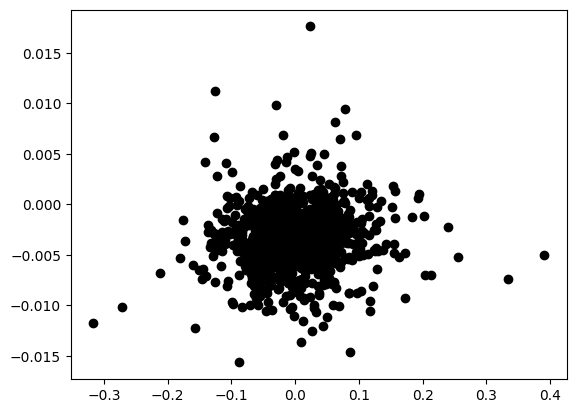

In [64]:
plt.scatter(y_test_s, y_pred_gdr, color='black', label='Actual')

# Set x-axis and y-axis limits
# plt.xlim(-10, 10)  # specify the limits for the x-axis
# plt.ylim(-10, 10)  # specify the limits for the y-axis

plt.show()

### Ridge regression first and second half

In [65]:
# using Ridge regression

# Initialize and train the Ridge Regression model with regularization (L2)
alpha = 0.1  # Regularization strength
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_train_s_scaled, y_train_s)

# Make predictions on the test set
y_pred_ridge = ridge_model.predict(X_test_s_scaled)

# Evaluate the model
mse_ridge = mean_squared_error(y_test_s, y_pred_ridge)
r2_ridge = r2_score(y_test_s, y_pred_ridge)

# Print the coefficients and intercept
#print("Coefficients:", ridge_model.coef_)
#print("Intercept:", ridge_model.intercept_)

# Print evaluation metrics
print("Mean Squared Error of the ridge regression:", mse_ridge)
print("R-squared of the ridge regression:", r2_ridge)
y_test_s= y_test_s.reset_index(drop=True) 

binary_ridge = np.sum((y_test_s * y_pred_ridge) > 0)/ len(y_test_s)
print(f"Percentage of correct direction predicted is: {binary_ridge}")

Mean Squared Error of the ridge regression: 0.003568487722229698
R-squared of the ridge regression: 0.0038071763162063066
Percentage of correct direction predicted is: 0.53


### Ridge hyperparameter tuning

In [66]:
from sklearn.model_selection import GridSearchCV
# Create a Ridge regression model
ridge_model = Ridge()

# Define a range of alpha values for hyperparameter tuning
alphas = [0.1, 100,500,1000, 10000]

# Perform hyperparameter tuning using GridSearchCV
param_grid = {'alpha': alphas}
grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_s_scaled, y_train_s)

# Get the best hyperparameters
best_alpha = grid_search.best_params_['alpha']

# Train the Ridge regression model with the best hyperparameters
ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X_train_s_scaled, y_train_s)

# Make predictions on the test set
y_pred_ridge2 = ridge_model.predict(X_test_s_scaled)

# Evaluate the model performance
mse_ridge2 = mean_squared_error(y_test_s, y_pred_ridge2)
r2_ridge2 = r2_score(y_test_s, y_pred_ridge2)
binary_ridge2 = np.sum((y_test_s * y_pred_ridge2) > 0)/ len(y_test_s)

print("Mean Squared Error of the ridge regression:", mse_ridge2)
print("R-squared of the ridge regression:", r2_ridge2)
print(f"Percentage of correct direction predicted is: {binary_ridge2}")
print("Alpha used is", best_alpha)

Mean Squared Error of the ridge regression: 0.003567240674148322
R-squared of the ridge regression: 0.004155307078073989
Percentage of correct direction predicted is: 0.525
Alpha used is 1000


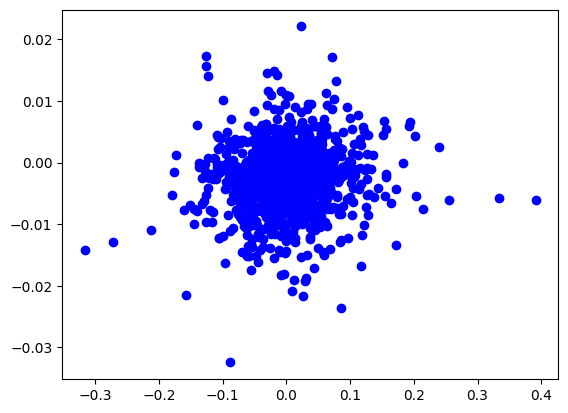

In [67]:
plt.scatter(y_test_s, y_pred_ridge2, color='blue')

# Set x-axis and y-axis limits
#plt.xlim(-2, 2)  # specify the limits for the x-axis
#plt.ylim(-2, 2)  # specify the limits for the y-axis

plt.show()

### Lasso regression first and second half

In [68]:
from sklearn.linear_model import Lasso

# Create and train a Lasso regression model
alpha = 0.1  # Regularization strength (adjust as needed)
lasso_model = Lasso(alpha=alpha)
lasso_model.fit(X_train_s_scaled, y_train_s)

# Make predictions on the test set
y_pred_lasso = lasso_model.predict(X_test_s_scaled)

# evaluation metrics
mse_lasso = mean_squared_error(y_test_s, y_pred_lasso)
r2_lasso = r2_score(y_test_s, y_pred_lasso)
binary_lasso = np.sum((y_test_s * y_pred_lasso) > 0)/ len(y_test_s)

print("Mean Squared Error of the ridge regression:", mse_lasso)
print("R-squared of the ridge regression:", r2_lasso)
print(f"Percentage of correct direction predicted is: {binary_lasso}")

Mean Squared Error of the ridge regression: 0.0035965182126450066
R-squared of the ridge regression: -0.004017923717659189
Percentage of correct direction predicted is: 0.4925


### Decision Tree regressor

In [69]:
# Create a decision tree regression model
dt_regressor = DecisionTreeRegressor(random_state=42)

# Fit the model to the training data
dt_regressor.fit(X_train_s_scaled, y_train_s)

# Make predictions on the test set
y_pred_dt = dt_regressor.predict(X_test_s_scaled)

# evaluation metrics
mse_dt = mean_squared_error(y_test_s, y_pred_dt)
r2_dt = r2_score(y_test_s, y_pred_dt)
binary_dt = np.sum((y_test_s * y_pred_dt) > 0)/ len(y_test_s)

print("Mean Squared Error of the ridge regression:", mse_dt)
print("R-squared of the ridge regression:", r2_dt)
print(f"Percentage of correct direction predicted is: {binary_dt}")

Mean Squared Error of the ridge regression: 0.007818294527397173
R-squared of the ridge regression: -1.1825853156565813
Percentage of correct direction predicted is: 0.49583333333333335


### Random forest regressor first and second half

In [70]:
from sklearn.ensemble import RandomForestRegressor
# Create a Random Forest regression model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_regressor.fit(X_train_s_scaled, y_train_s)

# Make predictions on the test set
y_pred_rf = rf_regressor.predict(X_test_s_scaled)

# evaluation metrics
mse_rf = mean_squared_error(y_test_s, y_pred_rf)
r2_rf = r2_score(y_test_s, y_pred_rf)
binary_rf = np.sum((y_test_s * y_pred_rf) > 0)/ len(y_test_s)

print("Mean Squared Error of the random forest regression:", mse_rf)
print("R-squared of the random forest regression:", r2_rf)
print(f"Percentage of correct direction predicted is: {binary_rf}")

Mean Squared Error of the random forest regression: 0.0037669589118038984
R-squared of the random forest regression: -0.051598807997581986
Percentage of correct direction predicted is: 0.5133333333333333


### Neural network both first half and second half

In [71]:
from tensorflow import keras
from tensorflow.keras import layers

# Create a simple neural network model
model = keras.Sequential([
    layers.Dense(10, activation='relu', input_shape=(5,)),
    layers.Dense(1)  # Output layer with 1 neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_s_scaled, y_train_s, epochs=100, validation_split=0.2, verbose=0)

# Make predictions on the test set
y_pred_nn = model.predict(X_test_s_scaled)

# evaluation metrics
mse_nn = mean_squared_error(y_test_s, y_pred_nn)
r2_nn = r2_score(y_test_s, y_pred_nn)
binary_nn = np.sum((y_test_s * y_pred_nn.ravel()) > 0)/ len(y_test_s)

print("Mean Squared Error of the neural network is:", mse_nn)
print("R-squared of the neural network is:", r2_nn)
print(f"Percentage of correct direction predicted is: {binary_nn}")





38/38 [==============================] - 0s 1ms/step
Mean Squared Error of the neural network is: 0.003675673703188855
R-squared of the neural network is: -0.026115276370362706
Percentage of correct direction predicted is: 0.5258333333333334


### S&P return descriptive analysis

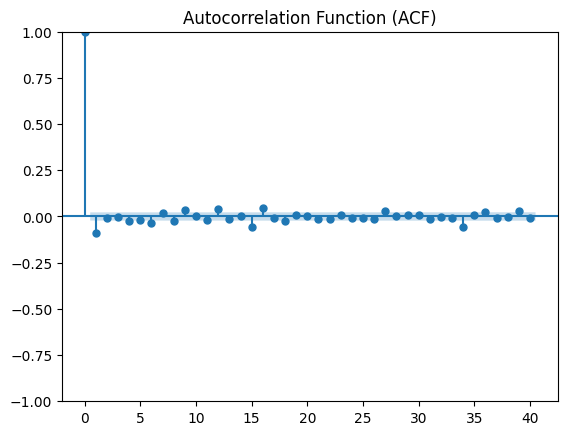

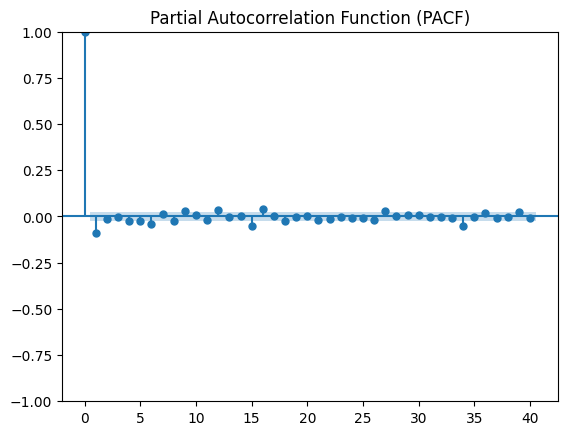

In [72]:
# first half
# Plot ACF
plot_acf(raw['sp_return'], lags=40, title='Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plot_pacf(raw['sp_return'], lags=40, title='Partial Autocorrelation Function (PACF)')
plt.show()

### GARCH model

GARCH model assumes the variance of the erorr terms is not constant <br>
The time series itself is stationary 

In [73]:
sp_return = raw[['Date','sp_return']]
sp_return.set_index('Date', inplace=True)

In [74]:
start = len(sp_return.loc[:'2023-01-01'])
end = len(sp_return)

In [75]:
pred = pd.DataFrame(index=sp_return.loc['2023-01-01':].index)
pred['vol'] = 0

In [76]:
j = 0 
for i in range(start,end):
    
    garch_model = arch_model(sp_return.iloc[:i]['sp_return']*100, vol='GARCH', p=1, q=1)

    # Fit the model
    garch_results = garch_model.fit()
    
    forecasts = garch_results.forecast(horizon=1)
    
    variance = forecasts.variance['h.1'][0]
    
    pred['vol'][j] = variance
    
    j += 1

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1336056153.6687217
Iteration:      2,   Func. Count:     15,   Neg. LLF: 728254173.5174701
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14358.756836164966
Iteration:      4,   Func. Count:     29,   Neg. LLF: 200517236.8490984
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10308.44899158063
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10178.101467240496
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10352.813767644624
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10166.31776856733
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10170.355337880448
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10166.1165310139
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10166.103509614893
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10166.103455477361
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10166.103453517178
Iteration:     14,   Func. Count:     84,   Neg. LLF: 101

Iteration:      7,   Func. Count:     48,   Neg. LLF: 10369.484146763829
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10179.651398035547
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10181.491555820014
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10179.39641149565
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10179.362139908562
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10179.362002294187
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10179.362001783415
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10179.362001783415
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 803978591093668.5
Iteration:      2,   Func. Count:     15,   Neg. LLF: 2928300972.1570435
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14362.896153576907
Iteration:      4,   Func. Count:     29,   Neg. LLF: 53654.17

Iteration:      8,   Func. Count:     54,   Neg. LLF: 10191.282412627814
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10193.102110600425
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10191.05509066303
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10191.025876279276
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10191.025772237499
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10191.025771590635
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10191.025771590635
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 800781144536584.1
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4221760039.8346977
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14379.12721821253
Iteration:      4,   Func. Count:     29,   Neg. LLF: 28961.82488296213
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10334.6902

Iteration:      2,   Func. Count:     15,   Neg. LLF: 130477260.8142662
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14396.552305650805
Iteration:      4,   Func. Count:     29,   Neg. LLF: 19666.787435753533
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10346.93748584594
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10215.478224870007
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10400.319113757287
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10205.084417836404
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10205.602321563798
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10204.887487101518
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10204.812397415768
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10204.812397418813
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10204.812397415768
            Iterations: 12
            Function evaluations: 75
            Gradient evalu

Iteration:      1,   Func. Count:      6,   Neg. LLF: 805688452028774.2
Iteration:      2,   Func. Count:     15,   Neg. LLF: 62638433.53538642
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14433.09206444772
Iteration:      4,   Func. Count:     29,   Neg. LLF: 48580.41273939144
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10361.175087818472
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10231.411990659893
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10401.112615938866
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10219.717503106749
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10221.054840059469
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10219.55495656645
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10219.52735795478
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10219.527283199157
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10219.527282491495
Optimization terminated successfully    (Exit mode 0)
   

Iteration:      1,   Func. Count:      6,   Neg. LLF: 802804158751896.8
Iteration:      2,   Func. Count:     15,   Neg. LLF: 196948092.63377184
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14441.466837215652
Iteration:      4,   Func. Count:     29,   Neg. LLF: 29815.267845208866
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10371.017983449465
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10241.100296052911
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10414.5100167561
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10229.755098104768
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10230.486300394285
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10229.595217240814
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10229.549975068498
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10229.549853229917
Iteration:     13,   Func. Count:     79,   Neg. LLF: 10229.549853228407
Optimization terminated successfully    (Exit mode 0)


Iteration:      1,   Func. Count:      6,   Neg. LLF: 4750569461.596048
Iteration:      2,   Func. Count:     15,   Neg. LLF: 129870809.46413456
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14490.856656974192
Iteration:      4,   Func. Count:     29,   Neg. LLF: 25074462475.04772
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10384.17036218286
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10255.494673344412
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10416.355865031775
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10243.044836271252
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10244.34094462698
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10242.956244346586
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10242.937442947274
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10242.937401693656
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10242.93740001608
Iteration:     14,   Func. Count:     84,   Neg. LLF: 10

Iteration:     10,   Func. Count:     65,   Neg. LLF: 10255.174544370126
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10255.14908979889
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10255.149034674396
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10255.149033489633
Iteration:     14,   Func. Count:     84,   Neg. LLF: 10255.149033488638
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10255.149033489633
            Iterations: 14
            Function evaluations: 84
            Gradient evaluations: 14
Iteration:      1,   Func. Count:      6,   Neg. LLF: 809749440657929.2
Iteration:      2,   Func. Count:     15,   Neg. LLF: 390438489.9032291
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14504.491119061804
Iteration:      4,   Func. Count:     29,   Neg. LLF: 173984.0999554117
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10397.420494729065
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10268.7218

Iteration:      1,   Func. Count:      6,   Neg. LLF: 805636619129771.2
Iteration:      2,   Func. Count:     15,   Neg. LLF: 129205891.96922062
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14512.221185089396
Iteration:      4,   Func. Count:     29,   Neg. LLF: 33856.624776138335
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10407.20261756581
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10277.581210720822
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10447.040884326843
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10265.879352110092
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10266.562440269825
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10265.746634506668
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10265.704192091674
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10265.704096291169
Iteration:     13,   Func. Count:     79,   Neg. LLF: 10265.704096291463
Optimization terminated successfully    (Exit mode 0)

Iteration:      2,   Func. Count:     15,   Neg. LLF: 95283753.25483365
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14513.934717464595
Iteration:      4,   Func. Count:     29,   Neg. LLF: 420797725.7097666
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10415.723305225212
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10286.814885051186
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10449.458814528252
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10273.891189837941
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10275.901377504908
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10273.748333366904
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10273.73408457044
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10273.734042486449
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10273.734040774885
Iteration:     14,   Func. Count:     84,   Neg. LLF: 10273.734040774376
Optimization terminated successfully    (Exit mode 0)


Iteration:      1,   Func. Count:      6,   Neg. LLF: 8782935303.203632
Iteration:      2,   Func. Count:     15,   Neg. LLF: 126159497.45379303
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14559.009345755698
Iteration:      4,   Func. Count:     29,   Neg. LLF: 24728656799.69918
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10432.502318816136
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10304.12847636165
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10457.585029605289
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10291.353410597123
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10291.834906058251
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10291.315960595792
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10291.263172023737
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10291.263142286072
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10291.263142285808
Optimization terminated successfully    (Exit mode 0)


Iteration:      1,   Func. Count:      6,   Neg. LLF: 659803198.8427348
Iteration:      2,   Func. Count:     15,   Neg. LLF: 295149589.7561742
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14567.395888471947
Iteration:      4,   Func. Count:     29,   Neg. LLF: 24853310373.77918
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10441.6446275645
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10313.966665199248
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10467.04544491924
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10300.890319984708
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10301.48533641284
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10300.836483832463
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10300.795818167422
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10300.795786848477
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10300.795786848217
Optimization terminated successfully    (Exit mode 0)
    

Iteration:     12,   Func. Count:     76,   Neg. LLF: 10309.953488436742
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10309.953488436488
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10309.953488436742
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2927936236.1113234
Iteration:      2,   Func. Count:     15,   Neg. LLF: 139081608.47474107
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14583.433039580766
Iteration:      4,   Func. Count:     29,   Neg. LLF: 180865169.9860347
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10451.677434845242
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10324.292894084723
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10476.52525999739
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10311.096814187453
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10311.53

Iteration:      4,   Func. Count:     29,   Neg. LLF: 25117194105.33796
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10460.462414952326
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10333.256212258284
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10485.355846100056
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10320.025049920752
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10320.336756692199
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10320.025279330896
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10319.943766702363
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10319.943734542907
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10319.94373454267
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10319.943734542907
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 82200782

Iteration:     11,   Func. Count:     71,   Neg. LLF: 10326.721332346231
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10326.721300470817
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10326.721300470625
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10326.721300470817
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1765018501.444388
Iteration:      2,   Func. Count:     15,   Neg. LLF: 667439226.8330407
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14609.621848433013
Iteration:      4,   Func. Count:     29,   Neg. LLF: 25108732800.44835
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10467.673647425483
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10340.552856180015
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10495.433403253744
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10327.465

Iteration:      3,   Func. Count:     22,   Neg. LLF: 14625.082832430695
Iteration:      4,   Func. Count:     29,   Neg. LLF: 24874895544.144806
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10475.33352030757
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10348.258139475385
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10502.847072112438
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10335.31443928464
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10335.244098311516
Iteration:     10,   Func. Count:     64,   Neg. LLF: 10335.24142726146
Iteration:     11,   Func. Count:     69,   Neg. LLF: 10335.259966101652
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10335.240752922004
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10335.24075111069
Iteration:     14,   Func. Count:     84,   Neg. LLF: 10335.240751110905
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10335.24075111069
            Iteratio

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1254525501.1915946
Iteration:      2,   Func. Count:     15,   Neg. LLF: 81071181.25735028
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14636.890708613508
Iteration:      4,   Func. Count:     29,   Neg. LLF: 734163472.4209588
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10482.03131258124
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10354.965299703272
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10513.574307632374
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10342.333152422127
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10342.3258688003
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10342.72833278288
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10342.253759945655
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10342.253725867626
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10342.253725867777
Optimization terminated successfully    (Exit mode 0)
   

Iteration:      4,   Func. Count:     29,   Neg. LLF: 813990036.9395177
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10486.77940800711
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10359.5267792696
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10530.636548296436
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10347.812620297826
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10348.141250075569
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10347.87204288568
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10347.713479585595
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10347.713451683785
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10347.71345168395
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10347.713451683785
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 851677197623

Iteration:      1,   Func. Count:      6,   Neg. LLF: 845673641502862.5
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4281521525.944731
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14663.257392190288
Iteration:      4,   Func. Count:     29,   Neg. LLF: 23575259898.42933
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10496.398313812311
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10369.188538499147
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10531.05159949894
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10356.950666078508
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10357.618545588517
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10356.922936736806
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10356.839610978685
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10356.839573958687
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10356.839573958854
Optimization terminated successfully    (Exit mode 0)
 

Iteration:      9,   Func. Count:     59,   Neg. LLF: 10368.766381433961
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10368.648976010052
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10368.457276506477
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10368.45723832715
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10368.45723832722
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10368.45723832715
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 6326202435.755388
Iteration:      2,   Func. Count:     15,   Neg. LLF: 118077119.21371938
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14677.802735753812
Iteration:      4,   Func. Count:     29,   Neg. LLF: 24413645764.536076
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10508.61959296761
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10382.16992

Iteration:      6,   Func. Count:     42,   Neg. LLF: 10391.846258813372
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10545.561049121254
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10379.10438921682
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10380.00253247425
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10379.048882592155
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10378.987636805388
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10378.987590840788
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10378.987590840887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10378.987590840788
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1349050268.0319455
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4294858183.0827665
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14699.74

Iteration:     13,   Func. Count:     80,   Neg. LLF: 10385.664700570385
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10385.664700570265
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 12412296236.479774
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4296006773.729763
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14706.742673216319
Iteration:      4,   Func. Count:     29,   Neg. LLF: 318071875.3399621
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10525.484029523714
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10399.120998113034
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10555.539763412813
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10386.315058614577
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10386.607295309848
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10386.37

Iteration:      2,   Func. Count:     15,   Neg. LLF: 68332328.08003557
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14728.259545152247
Iteration:      4,   Func. Count:     29,   Neg. LLF: 23879568249.43031
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10536.091140649374
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10409.563754083045
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10560.853364810557
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10396.865921519191
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10399.061084156343
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10396.734996506617
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10396.698779411505
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10396.698642389674
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10396.698638086167
Iteration:     14,   Func. Count:     84,   Neg. LLF: 10396.698638084625
Optimization terminated successfully    (Exit mode 0)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6526203913.658678
Iteration:      2,   Func. Count:     15,   Neg. LLF: 247397871.88675746
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14747.921025214935
Iteration:      4,   Func. Count:     29,   Neg. LLF: 408173754.22506857
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10546.153436352179
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10420.071167656664
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10567.340242220886
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10407.08325590006
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10409.189552140895
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10406.955270496754
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10406.919024271217
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10406.918888790751
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10406.918884180062
Iteration:     14,   Func. Count:     84,   Neg. LLF:

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1310885940.2927701
Iteration:      2,   Func. Count:     15,   Neg. LLF: 385878794.4965355
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14759.897704335504
Iteration:      4,   Func. Count:     29,   Neg. LLF: 521038337.1537877
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10554.661382748334
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10428.938039126828
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10574.973012523751
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10415.724273501586
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10417.272742005083
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10415.620808532201
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10415.578349629788
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10415.578206161957
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10415.578201800854
Iteration:     14,   Func. Count:     84,   Neg. LLF:

Iteration:      1,   Func. Count:      6,   Neg. LLF: 9815521931.492737
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4317509742.754938
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14797.059172111503
Iteration:      4,   Func. Count:     29,   Neg. LLF: 23036230605.074974
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10566.609076446795
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10440.500383341066
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10587.840702259446
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10428.241265456509
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10436.138110219112
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10427.85773723711
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10427.814799207063
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10427.814522671475
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10427.814511906274
Iteration:     14,   Func. Count:     84,   Neg. LLF: 

Iteration:      1,   Func. Count:      6,   Neg. LLF: 841310898292308.8
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4323549795.685684
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14802.191478262142
Iteration:      4,   Func. Count:     29,   Neg. LLF: 24551405292.280342
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10578.063352646599
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10452.550570012681
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10591.948893499393
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10439.05317813969
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10441.082874883807
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10438.92870916436
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10438.89347160266
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10438.893342601685
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10438.893337575457
Iteration:     14,   Func. Count:     84,   Neg. LLF: 10

Iteration:      2,   Func. Count:     15,   Neg. LLF: 4328054564.599053
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14820.061944847057
Iteration:      4,   Func. Count:     29,   Neg. LLF: 258972032.4057585
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10588.83609446017
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10463.750008809468
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10599.910755402901
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10449.893555097344
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10451.11624428405
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10449.807132701997
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10449.75941509522
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10449.759267367512
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10449.759262663323
Iteration:     14,   Func. Count:     84,   Neg. LLF: 10449.759262661331
Optimization terminated successfully    (Exit mode 0)
  

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2540439031.535128
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4328410399.073622
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14830.013586661586
Iteration:      4,   Func. Count:     29,   Neg. LLF: 1748889322.96985
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10595.118505545965
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10469.133592753828
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10614.982394979477
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10455.965975318823
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10458.862257520488
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10455.799974980891
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10455.767558667929
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10455.767422509696
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10455.767417501187
Iteration:     14,   Func. Count:     84,   Neg. LLF: 1

Iteration:     10,   Func. Count:     65,   Neg. LLF: 10461.665849738862
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10461.626493039164
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10461.626265849423
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10461.626258907185
Iteration:     14,   Func. Count:     84,   Neg. LLF: 10461.626258905078
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10461.626258907185
            Iterations: 14
            Function evaluations: 84
            Gradient evaluations: 14
Iteration:      1,   Func. Count:      6,   Neg. LLF: 861177440221352.2
Iteration:      2,   Func. Count:     15,   Neg. LLF: 169303063.89008692
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14842.153964980813
Iteration:      4,   Func. Count:     29,   Neg. LLF: 22282774941.718422
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10601.528748356244
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10474.6

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2317962310.530269
Iteration:      2,   Func. Count:     15,   Neg. LLF: 109462259.53836489
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14856.785652790799
Iteration:      4,   Func. Count:     29,   Neg. LLF: 1484453100.8093767
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10612.046868482397
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10485.465075042983
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10630.468469851985
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10472.900036215851
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10481.027530326048
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10472.481460990435
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10472.43520653514
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10472.434906101313
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10472.434895835395
Iteration:     14,   Func. Count:     84,   Neg. LLF:

In [77]:
mu = pred.mean()
std = pred.std()

pred_normalise = (pred - mu)/std

In [78]:
vix_test = raw[raw['Date'] >= '2023-01-01'][['Date','vix']]
vix_test.set_index('Date', inplace=True)

In [79]:
mu1 = vix_test.mean()
std1 = vix_test.std()
vix_test_normalise = (vix_test - mu1) / std1

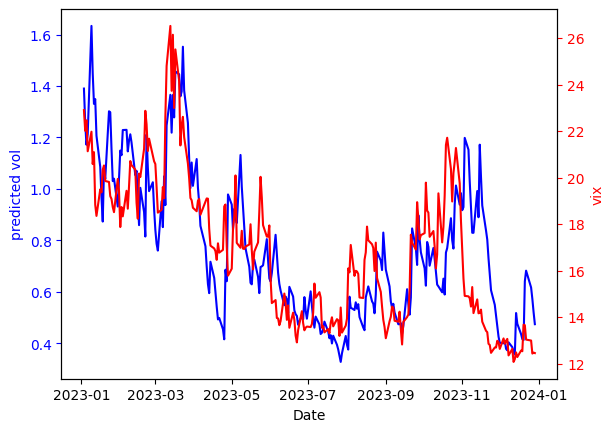

In [80]:
fig, ax1 = plt.subplots()
ax1.plot(pred['vol'], color='blue', label='predicted vol')
ax1.set_xlabel('Date')
ax1.set_ylabel('predicted vol', color='blue')
ax1.tick_params('y', colors='blue')

# Creating a secondary axis
ax2 = ax1.twinx()
ax2.plot(vix_test['vix'], color='red', label='actual vix')
ax2.set_ylabel('vix', color='red')
ax2.tick_params('y', colors='red')

In [81]:
mse_garch = mean_squared_error(pred_normalise, vix_test_normalise)
r2_garch = r2_score(pred_normalise, vix_test_normalise)
# binary_dt = np.sum((y_test_s * y_pred_dt) > 0)/ len(y_test_s)

print("Mean Squared Error of garch 1 day prediction:", mse_garch)
print("R-squared of garch 1 day prediction:", r2_garch)

Mean Squared Error of garch 1 day prediction: 0.4981006094023062
R-squared of garch 1 day prediction: 0.49995368509221627


### forward 30 days volatility forecast

In [82]:
pred_30 = pd.DataFrame(index=sp_return.loc['2023-01-01':].index)
pred_30['vol'] = 0

In [83]:
m = 0 
for n in range(start,end):
    
    garch_model = arch_model(sp_return.iloc[:n]['sp_return']*100, vol='GARCH', p=1, q=1)

    # Fit the model
    garch_results = garch_model.fit()
    
    forecasts = garch_results.forecast(horizon=30)
    
    variance = forecasts.variance.mean(axis=1)[0]
    
    pred_30['vol'][m] = variance
    
    m += 1

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1336056153.6687217
Iteration:      2,   Func. Count:     15,   Neg. LLF: 728254173.5174701
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14358.756836164966
Iteration:      4,   Func. Count:     29,   Neg. LLF: 200517236.8490984
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10308.44899158063
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10178.101467240496
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10352.813767644624
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10166.31776856733
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10170.355337880448
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10166.1165310139
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10166.103509614893
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10166.103455477361
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10166.103453517178
Iteration:     14,   Func. Count:     84,   Neg. LLF: 101

Iteration:      7,   Func. Count:     48,   Neg. LLF: 10365.646806005665
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10177.475922120686
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10179.521065275485
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10177.235783019063
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10177.206340164199
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10177.206227559935
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10177.206226892007
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10177.206226892007
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 803186043729142.6
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4218061337.5760913
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14364.111689026944
Iteration:      4,   Func. Count:     29,   Neg. LLF: 43374.3

Iteration:      8,   Func. Count:     54,   Neg. LLF: 10189.237133466868
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10190.547818323957
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10189.014413404857
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10188.974647935884
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10188.974501827279
Iteration:     13,   Func. Count:     79,   Neg. LLF: 10188.974501826142
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10188.974501827279
            Iterations: 13
            Function evaluations: 79
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2900004932.5384665
Iteration:      2,   Func. Count:     15,   Neg. LLF: 889241410.2666646
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14378.145528901716
Iteration:      4,   Func. Count:     29,   Neg. LLF: 37768.255790570605
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10332.1

Iteration:     11,   Func. Count:     71,   Neg. LLF: 10200.448471242993
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10200.448471246524
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10200.448471242993
            Iterations: 12
            Function evaluations: 75
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2179224661.323659
Iteration:      2,   Func. Count:     15,   Neg. LLF: 471731451.776594
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14393.4637597888
Iteration:      4,   Func. Count:     29,   Neg. LLF: 20450.080195332674
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10344.104474551757
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10212.652504158235
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10397.046801068664
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10202.233462729033
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10202.78129

Iteration:      1,   Func. Count:      6,   Neg. LLF: 797701307354855.2
Iteration:      2,   Func. Count:     15,   Neg. LLF: 128611973.63846871
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14406.328481138753
Iteration:      4,   Func. Count:     29,   Neg. LLF: 22803.188550553605
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10354.311590760171
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10223.2065398004
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10406.095577610326
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10212.443722083995
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10213.083230882523
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10212.23273171185
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10212.170215107719
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10212.169981473897
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10212.16998089644
Optimization terminated successfully    (Exit mode 0)
  

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2622678771.7483826
Iteration:      2,   Func. Count:     15,   Neg. LLF: 144687304.86046252
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14436.790757040475
Iteration:      4,   Func. Count:     29,   Neg. LLF: 38574.38686771334
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10365.674960374552
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10235.992810036852
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10407.346528245787
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10224.336423947381
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10225.443885219149
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10224.16298911782
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10224.129631035332
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10224.129538586481
Iteration:     13,   Func. Count:     79,   Neg. LLF: 10224.129538588166
Optimization terminated successfully    (Exit mode 0)

Iteration:      6,   Func. Count:     42,   Neg. LLF: 10249.185648213588
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10409.883556118044
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10236.6931039308
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10238.220022502657
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10236.582302016104
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10236.565068063785
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10236.565024964493
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10236.565023244584
Iteration:     14,   Func. Count:     84,   Neg. LLF: 10236.565023244004
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10236.565023244584
            Iterations: 14
            Function evaluations: 84
            Gradient evaluations: 14
Iteration:      1,   Func. Count:      6,   Neg. LLF: 817050518762442.8
Iteration:      2,   Func. Count:     15,   Neg. LLF: 423540888

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3936708904.506371
Iteration:      2,   Func. Count:     15,   Neg. LLF: 90105456.50065726
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14496.912410536372
Iteration:      4,   Func. Count:     29,   Neg. LLF: 39442.01939452859
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10391.010863559855
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10261.347846871151
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10428.612505063944
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10249.795117721937
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10250.538315042104
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10249.682533367442
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10249.642267133902
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10249.642183330283
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10249.642182817024
Optimization terminated successfully    (Exit mode 0)


Iteration:      4,   Func. Count:     29,   Neg. LLF: 30740.101993429387
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10400.313693132804
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10270.656950012497
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10440.374168323178
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10259.23575452536
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10259.758890426532
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10259.122245269453
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10259.069647568966
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10259.069640889333
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10259.069640889144
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10259.069640889333
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2833591

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1402598601.7620113
Iteration:      2,   Func. Count:     15,   Neg. LLF: 217708179.6023831
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14512.939930824097
Iteration:      4,   Func. Count:     29,   Neg. LLF: 51115.15185844408
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10409.06263899431
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10279.631225688525
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10446.521851542282
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10267.489624977734
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10268.59500755328
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10267.345137336488
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10267.31697774894
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10267.316910432104
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10267.31690969129
Optimization terminated successfully    (Exit mode 0)
   

Iteration:     13,   Func. Count:     80,   Neg. LLF: 10273.734040774885
Iteration:     14,   Func. Count:     84,   Neg. LLF: 10273.734040774376
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10273.734040774885
            Iterations: 14
            Function evaluations: 84
            Gradient evaluations: 14
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1939587021.1309793
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4246030552.4050508
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14513.016158903645
Iteration:      4,   Func. Count:     29,   Neg. LLF: 25091471909.45322
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10416.425788372318
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10287.333672974819
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10450.973383863351
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10274.419897315138
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10276.5

Iteration:      7,   Func. Count:     48,   Neg. LLF: 10454.543136820213
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10287.475675258138
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10288.174193611232
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10287.4115629099
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10287.376739276817
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10287.376708582175
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10287.376708581914
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10287.376708582175
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 815270171928180.5
Iteration:      2,   Func. Count:     15,   Neg. LLF: 64933428.028294235
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14551.958362244082
Iteration:      4,   Func. Count:     29,   Neg. LLF: 248989626

Iteration:     10,   Func. Count:     65,   Neg. LLF: 10295.993899779623
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10295.956823466115
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10295.95679192596
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10295.956791925702
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10295.95679192596
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3379977448.032141
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4255803152.3411255
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14562.167150867335
Iteration:      4,   Func. Count:     29,   Neg. LLF: 24931297642.112587
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10437.642506032855
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10309.924647799358
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10464.113

Iteration:      1,   Func. Count:      6,   Neg. LLF: 11121251362.696404
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1154766689.1914816
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14581.612036636607
Iteration:      4,   Func. Count:     29,   Neg. LLF: 24923560765.6345
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10449.890738712707
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10322.429557739302
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10474.22935045868
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10309.28209367759
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10309.72168484193
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10309.249953480547
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10309.1937463521
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10309.193714579154
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10309.193714578896
Optimization terminated successfully    (Exit mode 0)
    

Iteration:      3,   Func. Count:     22,   Neg. LLF: 14591.807359114451
Iteration:      4,   Func. Count:     29,   Neg. LLF: 225922535.6857593
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10457.557069064977
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10330.353205113704
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10481.856555221677
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10317.124973036143
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10317.451893013887
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10317.119314494772
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10317.042190942713
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10317.042158603152
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10317.042158602908
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10317.042158603152
            Iterations: 13
            Function evaluations: 80
            Gradient eval

Iteration:      8,   Func. Count:     54,   Neg. LLF: 10324.344197144837
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10324.488090954412
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10324.435350254718
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10324.268167978407
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10324.26813564973
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10324.268135649509
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10324.26813564973
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 826458670957333.8
Iteration:      2,   Func. Count:     15,   Neg. LLF: 303204969.21966195
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14606.214923377396
Iteration:      4,   Func. Count:     29,   Neg. LLF: 2539661170.7207437
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10465.266

Iteration:      1,   Func. Count:      6,   Neg. LLF: 15737248898.687199
Iteration:      2,   Func. Count:     15,   Neg. LLF: 74412573.17394742
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14617.769958350837
Iteration:      4,   Func. Count:     29,   Neg. LLF: 24996579379.339035
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10472.090942622162
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10345.028250887279
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10499.286465457124
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10331.984721249843
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10331.964362408773
Iteration:     10,   Func. Count:     64,   Neg. LLF: 10332.3873412083
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10331.912455373284
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10331.911955025731
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10331.91195294066
Iteration:     14,   Func. Count:     84,   Neg. LLF: 1

Iteration:      3,   Func. Count:     22,   Neg. LLF: 14628.430073240635
Iteration:      4,   Func. Count:     29,   Neg. LLF: 24817850763.846443
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10478.418551929359
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10351.544007144208
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10507.27962049587
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10338.604976149192
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10338.539441279972
Iteration:     10,   Func. Count:     64,   Neg. LLF: 10338.698397367669
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10338.531367278469
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10338.531226849896
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10338.531225586565
Iteration:     14,   Func. Count:     84,   Neg. LLF: 10338.531225586696
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10338.531225586565
            Iter

Iteration:      1,   Func. Count:      6,   Neg. LLF: 57817138142.12993
Iteration:      2,   Func. Count:     15,   Neg. LLF: 164550475.6473337
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14645.878012403806
Iteration:      4,   Func. Count:     29,   Neg. LLF: 23473647391.37598
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10484.32486301383
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10357.106379784094
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10523.302021080483
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10345.073577899286
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10345.356790031925
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10345.146000043089
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10344.978456347879
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10344.978425527206
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10344.978425527343
Optimization terminated successfully    (Exit mode 0)
 

Iteration:     13,   Func. Count:     80,   Neg. LLF: 10350.833946033817
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10350.833946033625
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 853730779833467.6
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4279130375.3151326
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14661.026866685552
Iteration:      4,   Func. Count:     29,   Neg. LLF: 22356902015.21426
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10490.279196014935
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10362.896389784604
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10536.42674426236
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10351.46573880977
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10352.572474878558
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10351.3977

Iteration:      1,   Func. Count:      6,   Neg. LLF: 5765663349.812718
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4283431041.176242
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14669.831282614166
Iteration:      4,   Func. Count:     29,   Neg. LLF: 604132128.3166518
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10499.622429508467
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10372.43646968692
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10534.05974407948
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10360.222250188279
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10361.114116393019
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10360.169031068297
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10360.103097990828
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10360.103058784704
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10360.103058784869
Optimization terminated successfully    (Exit mode 0)
  

Iteration:     12,   Func. Count:     76,   Neg. LLF: 10368.45723832715
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10368.45723832722
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10368.45723832715
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 6326202435.755388
Iteration:      2,   Func. Count:     15,   Neg. LLF: 118077119.21371938
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14677.802735753812
Iteration:      4,   Func. Count:     29,   Neg. LLF: 24413645764.536076
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10508.61959296761
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10382.169923759562
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10537.617182177793
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10369.273809955095
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10369.33775

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1349050268.0319455
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4294858183.0827665
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14699.745873000322
Iteration:      4,   Func. Count:     29,   Neg. LLF: 24129722746.043854
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10519.244108378673
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10392.581410430208
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10546.859516229946
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10379.843770930453
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10380.691759328
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10379.792513062608
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10379.727670710232
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10379.727625251533
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10379.727625251646
Optimization terminated successfully    (Exit mode 0)


Iteration:      1,   Func. Count:      6,   Neg. LLF: 12412296236.479774
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4296006773.729763
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14706.742673216319
Iteration:      4,   Func. Count:     29,   Neg. LLF: 318071875.3399621
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10525.484029523714
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10399.120998113034
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10555.539763412813
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10386.315058614577
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10386.607295309848
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10386.37398562303
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10386.217964040014
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10386.217925418092
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10386.21792541819
Optimization terminated successfully    (Exit mode 0)
 

Iteration:      6,   Func. Count:     42,   Neg. LLF: 10410.621638791226
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10560.63151726661
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10397.69835863902
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10399.1005035024
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10397.605423823396
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10397.559902120702
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10397.559754227672
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10397.559750301054
Iteration:     14,   Func. Count:     84,   Neg. LLF: 10397.559750299231
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10397.559750301054
            Iterations: 14
            Function evaluations: 84
            Gradient evaluations: 14
Iteration:      1,   Func. Count:      6,   Neg. LLF: 60458588728.57795
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4304574137.

Iteration:      1,   Func. Count:      6,   Neg. LLF: 12423259794.734472
Iteration:      2,   Func. Count:     15,   Neg. LLF: 174771383.47545636
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14752.57183656574
Iteration:      4,   Func. Count:     29,   Neg. LLF: 24242743816.510963
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10548.574334973833
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10422.597562427716
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10569.012276140267
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10409.52136523631
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10411.430977219192
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10409.401995223052
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10409.364298397999
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10409.36416243155
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10409.36415790391
Iteration:     14,   Func. Count:     84,   Neg. LLF: 1

Iteration:     11,   Func. Count:     70,   Neg. LLF: 10418.618082278168
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10418.617944872733
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10418.617940086071
Iteration:     14,   Func. Count:     84,   Neg. LLF: 10418.617940084487
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10418.617940086071
            Iterations: 14
            Function evaluations: 84
            Gradient evaluations: 14
Iteration:      1,   Func. Count:      6,   Neg. LLF: 845303913206006.5
Iteration:      2,   Func. Count:     15,   Neg. LLF: 139125948.6207283
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14772.649958101596
Iteration:      4,   Func. Count:     29,   Neg. LLF: 24129049416.368233
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10558.959074096862
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10433.23884752254
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10578.216

Iteration:      2,   Func. Count:     15,   Neg. LLF: 156223094.74266696
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14799.177559927812
Iteration:      4,   Func. Count:     29,   Neg. LLF: 23631803111.973495
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10570.396592471187
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10444.585531878782
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10589.37083403899
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10431.843653668442
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10437.325065120085
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10431.577275284944
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10431.544051911176
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10431.543870824413
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10431.543862885854
Iteration:     14,   Func. Count:     84,   Neg. LLF: 10431.5438628844
Optimization terminated successfully    (Exit mode 0)


Iteration:      7,   Func. Count:     48,   Neg. LLF: 10596.61433777763
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10444.32971284294
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10446.58528707119
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10444.194552915747
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10444.160752063726
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10444.160622831521
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10444.160617541907
Iteration:     14,   Func. Count:     84,   Neg. LLF: 10444.160617540518
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10444.160617541907
            Iterations: 14
            Function evaluations: 84
            Gradient evaluations: 14
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3595405793.1491556
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4327918159.566626
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14817.1667

Iteration:      1,   Func. Count:      6,   Neg. LLF: 844618583142431.5
Iteration:      2,   Func. Count:     15,   Neg. LLF: 148133016.01659292
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14826.474302356666
Iteration:      4,   Func. Count:     29,   Neg. LLF: 24386247106.623047
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10593.066883542717
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10467.66795772095
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10608.523000506146
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10454.11281611025
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10456.219421586746
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10453.980942994658
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10453.945701720586
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10453.945569782089
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10453.945564811735
Iteration:     14,   Func. Count:     84,   Neg. LLF: 

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3189224077.5660496
Iteration:      2,   Func. Count:     15,   Neg. LLF: 141624910.573708
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14836.182665213611
Iteration:      4,   Func. Count:     29,   Neg. LLF: 565281047.6335131
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10599.877882122986
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10473.320387922842
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10624.45353280057
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10460.716374383053
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10465.427547712905
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10460.470543659732
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10460.436400335213
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10460.436225899008
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10460.436219946387
Iteration:     14,   Func. Count:     84,   Neg. LLF: 1

Iteration:      4,   Func. Count:     29,   Neg. LLF: 658857503.8719668
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10606.297745444906
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10479.677379303623
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10638.458062734946
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10468.608295784032
Iteration:      9,   Func. Count:     60,   Neg. LLF: 10480.55840289713
Iteration:     10,   Func. Count:     66,   Neg. LLF: 10467.682144129367
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10467.681334320057
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10467.68131736173
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10467.681317363898
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10467.68131736173
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1495234714

In [84]:
mu_30 = pred_30.mean()
std_30 = pred_30.std()

pred_30_normalise = (pred_30 - mu_30)/std_30

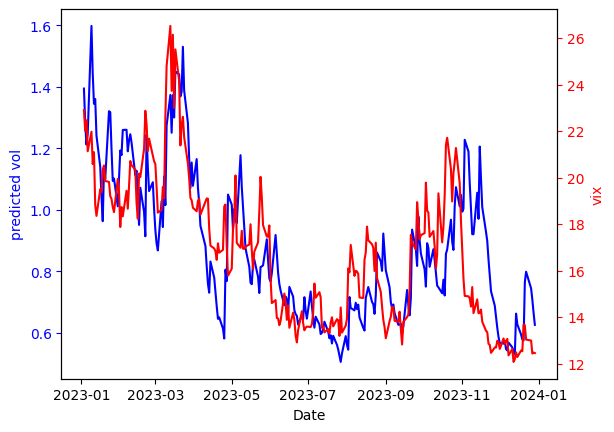

In [85]:
fig, ax1 = plt.subplots()
ax1.plot(pred_30['vol'], color='blue', label='predicted vol')
ax1.set_xlabel('Date')
ax1.set_ylabel('predicted vol', color='blue')
ax1.tick_params('y', colors='blue')

# Creating a secondary axis
ax2 = ax1.twinx()
ax2.plot(vix_test['vix'], color='red', label='actual vix')
ax2.set_ylabel('vix', color='red')
ax2.tick_params('y', colors='red')

In [86]:
mse_garch30 = mean_squared_error(pred_30_normalise, vix_test_normalise)
r2_garch30 = r2_score(pred_30_normalise, vix_test_normalise)
# binary_dt = np.sum((y_test_s * y_pred_dt) > 0)/ len(y_test_s)

print("Mean Squared Error of garch 30 day prediction:", mse_garch30)
print("R-squared of garch 30 day prediction:", r2_garch30)

Mean Squared Error of garch 30 day prediction: 0.4947728942000385
R-squared of garch 30 day prediction: 0.5032943991819926


### end of 30 day volatility

In [87]:
pred_30day = pd.DataFrame(index=sp_return.loc['2023-01-01':].index)
pred_30day['vol'] = 0

In [88]:
q = 0 
for p in range(start,end):
    
    garch_model = arch_model(sp_return.iloc[:p]['sp_return']*100, vol='GARCH', p=1, q=1)

    # Fit the model
    garch_results = garch_model.fit()
    
    forecasts = garch_results.forecast(horizon=30)
    
    variance = forecasts.variance['h.30'][0]
    
    pred_30day['vol'][q] = variance
    
    q += 1

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1336056153.6687217
Iteration:      2,   Func. Count:     15,   Neg. LLF: 728254173.5174701
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14358.756836164966
Iteration:      4,   Func. Count:     29,   Neg. LLF: 200517236.8490984
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10308.44899158063
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10178.101467240496
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10352.813767644624
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10166.31776856733
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10170.355337880448
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10166.1165310139
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10166.103509614893
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10166.103455477361
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10166.103453517178
Iteration:     14,   Func. Count:     84,   Neg. LLF: 101

Iteration:     13,   Func. Count:     80,   Neg. LLF: 10177.206226892007
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10177.206226892007
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 803186043729142.6
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4218061337.5760913
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14364.111689026944
Iteration:      4,   Func. Count:     29,   Neg. LLF: 43374.39625057717
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10320.659657403092
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10189.88732310278
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10367.513235097287
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10178.582701380688
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10180.528489071514
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10178.334

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2900004932.5384665
Iteration:      2,   Func. Count:     15,   Neg. LLF: 889241410.2666646
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14378.145528901716
Iteration:      4,   Func. Count:     29,   Neg. LLF: 37768.255790570605
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10332.199829283618
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10201.586382418991
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10378.310863451385
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10190.290394903066
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10191.853836453822
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10190.06512801367
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10190.031372036588
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10190.031250758686
Iteration:     13,   Func. Count:     79,   Neg. LLF: 10190.03125075965
Optimization terminated successfully    (Exit mode 0)


Iteration:     11,   Func. Count:     71,   Neg. LLF: 10201.96443267418
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10201.964432676761
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10201.96443267418
            Iterations: 12
            Function evaluations: 75
            Gradient evaluations: 12
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4589232330.198017
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4224838658.4701657
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14395.465036348116
Iteration:      4,   Func. Count:     29,   Neg. LLF: 22850.968645467157
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10345.275495915937
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10214.07421733774
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10396.527562133535
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10203.438540648242
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10204.1020

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1947113680.0307136
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4227106012.286916
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14414.70565377163
Iteration:      4,   Func. Count:     29,   Neg. LLF: 27097.017470895116
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10357.193419223957
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10226.542617147195
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10405.197938745878
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10215.457572753823
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10216.304022223829
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10215.256512309028
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10215.208118605911
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10215.207955205573
Iteration:     13,   Func. Count:     79,   Neg. LLF: 10215.207955202453
Optimization terminated successfully    (Exit mode 0)

Iteration:     11,   Func. Count:     70,   Neg. LLF: 10227.190499220698
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10227.190384187723
Iteration:     13,   Func. Count:     79,   Neg. LLF: 10227.190384187275
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10227.190384187723
            Iterations: 13
            Function evaluations: 79
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 802804158751896.8
Iteration:      2,   Func. Count:     15,   Neg. LLF: 196948092.63377184
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14441.466837215652
Iteration:      4,   Func. Count:     29,   Neg. LLF: 29815.267845208866
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10371.017983449465
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10241.100296052911
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10414.5100167561
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10229.755

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4750569461.596048
Iteration:      2,   Func. Count:     15,   Neg. LLF: 129870809.46413456
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14490.856656974192
Iteration:      4,   Func. Count:     29,   Neg. LLF: 25074462475.04772
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10384.17036218286
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10255.494673344412
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10416.355865031775
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10243.044836271252
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10244.34094462698
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10242.956244346586
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10242.937442947274
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10242.937401693656
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10242.93740001608
Iteration:     14,   Func. Count:     84,   Neg. LLF: 10

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2461892835.318186
Iteration:      2,   Func. Count:     15,   Neg. LLF: 284255689.2804901
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14507.15795927038
Iteration:      4,   Func. Count:     29,   Neg. LLF: 35350.06491222949
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10399.256245064986
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10269.716396098374
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10437.498301925036
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10258.14417287696
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10258.77381470418
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10258.031494663315
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10257.985943195092
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10257.985932746462
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10257.985932746275
Optimization terminated successfully    (Exit mode 0)
   

Iteration:     12,   Func. Count:     75,   Neg. LLF: 10267.316910432104
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10267.31690969129
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10267.31690969129
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1303442665.9186368
Iteration:      2,   Func. Count:     15,   Neg. LLF: 65321693.50667316
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14513.798247119707
Iteration:      4,   Func. Count:     29,   Neg. LLF: 39180.66219081433
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10410.786897719561
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10281.370673876023
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10448.576064136407
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10269.474635941278
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10270.2200

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3852542211.1909223
Iteration:      2,   Func. Count:     15,   Neg. LLF: 545890384.836364
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14519.77920835049
Iteration:      4,   Func. Count:     29,   Neg. LLF: 39810.97552007012
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10419.198001831814
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10290.226216540872
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10454.67348459368
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10278.14807307851
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10278.699970641472
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10278.045422591902
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10277.998673517004
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10277.998660613735
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10277.998660613537
Optimization terminated successfully    (Exit mode 0)
   

Iteration:     10,   Func. Count:     65,   Neg. LLF: 10291.315960595792
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10291.263172023737
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10291.263142286072
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10291.263142285808
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10291.263142286072
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1291327163.8372052
Iteration:      2,   Func. Count:     15,   Neg. LLF: 164085890.8180161
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14559.720591426621
Iteration:      4,   Func. Count:     29,   Neg. LLF: 528992181.33602405
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10433.353753487416
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10305.207244795565
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10458.3

Iteration:      4,   Func. Count:     29,   Neg. LLF: 439300532.8282609
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10440.383325072864
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10312.668891503132
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10466.098575516191
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10299.597239374285
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10300.179324635781
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10299.546517524628
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10299.50476170173
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10299.504730322566
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10299.504730322307
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10299.504730322566
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 65980319

Iteration:     13,   Func. Count:     80,   Neg. LLF: 10309.193714578896
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10309.193714579154
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1330984389.2580295
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4261350683.704159
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14581.440622048362
Iteration:      4,   Func. Count:     29,   Neg. LLF: 24997601555.78829
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10450.648239548173
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10323.236782665783
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10475.329117920468
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10310.04200894389
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10310.513630912588
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10310.005

Iteration:      1,   Func. Count:      6,   Neg. LLF: 821277045624334.2
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4264950059.559443
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14593.409484684013
Iteration:      4,   Func. Count:     29,   Neg. LLF: 25129479603.499336
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10459.182741213968
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10331.962567064482
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10484.465180055864
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10318.724110410458
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10319.080333572641
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10318.71264140148
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10318.64180116742
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10318.64176907327
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10318.641769073038
Optimization terminated successfully    (Exit mode 0)
  

Iteration:      5,   Func. Count:     36,   Neg. LLF: 10467.02072599886
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10339.909345610711
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10493.953070351678
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10326.795322253936
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10326.880274718122
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10326.960761955857
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10326.721332346231
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10326.721300470817
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10326.721300470625
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10326.721300470817
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1765018501.444388
Iteration:      2,   Func. Count:     15,   Neg. LLF: 66743922

Iteration:      5,   Func. Count:     36,   Neg. LLF: 10475.831590056383
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10348.811746430933
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10504.719591355082
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10335.934661112886
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10335.864366208982
Iteration:     10,   Func. Count:     64,   Neg. LLF: 10335.881065907763
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10335.862716504562
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10335.86050715662
Iteration:     13,   Func. Count:     81,   Neg. LLF: 10335.860506175974
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10335.860506175974
            Iterations: 13
            Function evaluations: 81
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 5712732198.911343
Iteration:      2,   Func. Count:     15,   Neg. LLF: 12193097

Iteration:     10,   Func. Count:     65,   Neg. LLF: 10343.851754817022
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10343.467356859386
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10343.467324731697
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10343.467324731862
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10343.467324731697
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 843766425163894.0
Iteration:      2,   Func. Count:     15,   Neg. LLF: 289752274.050594
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14643.242477647495
Iteration:      4,   Func. Count:     29,   Neg. LLF: 325677293.9413537
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10483.958089748214
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10356.777500021659
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10520.1505

Iteration:      9,   Func. Count:     59,   Neg. LLF: 10352.032295549307
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10350.895723515087
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10350.83397860432
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10350.833946033625
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10350.833946033817
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10350.833946033625
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 853730779833467.6
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4279130375.3151326
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14661.026866685552
Iteration:      4,   Func. Count:     29,   Neg. LLF: 22356902015.21426
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10490.279196014935
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10362.896

Iteration:      1,   Func. Count:      6,   Neg. LLF: 845370396177266.5
Iteration:      2,   Func. Count:     15,   Neg. LLF: 2841609510.0296116
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14669.42911998364
Iteration:      4,   Func. Count:     29,   Neg. LLF: 322056393.92109406
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10500.143572405766
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10373.175453954947
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10534.310469978212
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10360.831052679467
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10361.32425880215
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10360.832983613805
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10360.726264460805
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10360.726227863943
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10360.7262278641
Optimization terminated successfully    (Exit mode 0)
  

Iteration:      7,   Func. Count:     48,   Neg. LLF: 10537.617182177793
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10369.273809955095
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10369.337755433171
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10369.525978872356
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10369.187568456693
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10369.187530783678
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10369.187530783778
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10369.187530783678
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3710504901.082191
Iteration:      2,   Func. Count:     15,   Neg. LLF: 242449485.2832474
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14684.712742429523
Iteration:      4,   Func. Count:     29,   Neg. LLF: 24043168

Iteration:      5,   Func. Count:     36,   Neg. LLF: 10519.822937042838
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10393.219757512266
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10548.585897507732
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10380.527981730616
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10381.347423160314
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10380.479473644506
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10380.411770198763
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10380.411725657217
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10380.411725657345
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10380.411725657217
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1113693728.1374621
Iteration:      2,   Func. Count:     15,   Neg. LLF: 487874

Iteration:      1,   Func. Count:      6,   Neg. LLF: 70970271949.92604
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4297345821.359704
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14710.769706353534
Iteration:      4,   Func. Count:     29,   Neg. LLF: 842500067.2477793
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10526.632309733146
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10400.161601211888
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10557.502458655694
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10387.525131239508
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10388.187022240316
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10387.495586343623
Iteration:     11,   Func. Count:     71,   Neg. LLF: 10387.412882129369
Iteration:     12,   Func. Count:     76,   Neg. LLF: 10387.412840657023
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10387.412840657176
Optimization terminated successfully    (Exit mode 0)


Iteration:      7,   Func. Count:     48,   Neg. LLF: 10564.178533038363
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10400.224711539626
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10404.358794561973
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10400.017173852571
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10399.985451829136
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10399.98529941164
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10399.985293751131
Iteration:     14,   Func. Count:     84,   Neg. LLF: 10399.985293749734
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10399.985293751131
            Iterations: 14
            Function evaluations: 84
            Gradient evaluations: 14
Iteration:      1,   Func. Count:      6,   Neg. LLF: 846838302330712.5
Iteration:      2,   Func. Count:     15,   Neg. LLF: 130749363.5226841
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14738.339

Iteration:      1,   Func. Count:      6,   Neg. LLF: 5445375240.15686
Iteration:      2,   Func. Count:     15,   Neg. LLF: 4309513123.788361
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14753.21235927336
Iteration:      4,   Func. Count:     29,   Neg. LLF: 24348876018.269592
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10549.58126039304
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10423.6910391547
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10569.568450213294
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10410.502988827488
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10412.026996700788
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10410.402088929404
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10410.359635531588
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10410.359493881657
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10410.359489581622
Iteration:     14,   Func. Count:     84,   Neg. LLF: 1041

Iteration:      5,   Func. Count:     36,   Neg. LLF: 10558.959074096862
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10433.23884752254
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10578.216994613422
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10420.13080205989
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10422.611880747121
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10419.98422685016
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10419.949804761616
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10419.949666751447
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10419.949661590765
Iteration:     14,   Func. Count:     84,   Neg. LLF: 10419.949661589299
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10419.949661590765
            Iterations: 14
            Function evaluations: 84
            Gradient evaluations: 14
Iteration:      1,   Func. Count:      6,   Neg. LLF: 848463004

Iteration:      8,   Func. Count:     54,   Neg. LLF: 10431.843653668442
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10437.325065120085
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10431.577275284944
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10431.544051911176
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10431.543870824413
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10431.543862885854
Iteration:     14,   Func. Count:     84,   Neg. LLF: 10431.5438628844
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10431.543862885854
            Iterations: 14
            Function evaluations: 84
            Gradient evaluations: 14
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3137396888.7371554
Iteration:      2,   Func. Count:     15,   Neg. LLF: 354528012.45421743
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14799.348136524648
Iteration:      4,   Func. Count:     29,   Neg. LLF: 12014055

Iteration:     13,   Func. Count:     80,   Neg. LLF: 10443.234647199346
Iteration:     14,   Func. Count:     84,   Neg. LLF: 10443.234647197874
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10443.234647199346
            Iterations: 14
            Function evaluations: 84
            Gradient evaluations: 14
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2182350724.934825
Iteration:      2,   Func. Count:     15,   Neg. LLF: 103063145.38778302
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14809.780061975789
Iteration:      4,   Func. Count:     29,   Neg. LLF: 3723163661.4102554
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10583.191144836004
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10457.85974597668
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10596.61433777763
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10444.32971284294
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10446.5852

Iteration:     12,   Func. Count:     75,   Neg. LLF: 10452.554814656885
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10452.554809924382
Iteration:     14,   Func. Count:     84,   Neg. LLF: 10452.554809922605
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10452.554809924382
            Iterations: 14
            Function evaluations: 84
            Gradient evaluations: 14
Iteration:      1,   Func. Count:      6,   Neg. LLF: 842886243635910.5
Iteration:      2,   Func. Count:     15,   Neg. LLF: 75614985.5741505
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14825.23647703455
Iteration:      4,   Func. Count:     29,   Neg. LLF: 258247152.96976548
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10592.362231440551
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10467.116620899054
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10606.350084133024
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10453.4327

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1250720126.0434837
Iteration:      2,   Func. Count:     15,   Neg. LLF: 560155924.3778747
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14833.514765060963
Iteration:      4,   Func. Count:     29,   Neg. LLF: 3910448915.2413054
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10598.087169493845
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10471.60917294411
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10621.796719794029
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10458.820630421742
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10462.549349203106
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10458.618606968139
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10458.586170494906
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10458.58602071218
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10458.586015570416
Iteration:     14,   Func. Count:     84,   Neg. LLF: 

Iteration:     11,   Func. Count:     70,   Neg. LLF: 10466.203073021752
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10466.202365515295
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10466.202350954787
Iteration:     14,   Func. Count:     84,   Neg. LLF: 10466.20235094953
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10466.202350954787
            Iterations: 14
            Function evaluations: 84
            Gradient evaluations: 14
Iteration:      1,   Func. Count:      6,   Neg. LLF: 867960408003201.8
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1920826966.9953713
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14854.966219073758
Iteration:      4,   Func. Count:     29,   Neg. LLF: 21222533627.208885
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10605.616999745187
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10479.023139857312
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10636.09

Iteration:     13,   Func. Count:     80,   Neg. LLF: 10475.187595922325
Iteration:     14,   Func. Count:     84,   Neg. LLF: 10475.187595918103
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10475.187595922325
            Iterations: 14
            Function evaluations: 84
            Gradient evaluations: 14


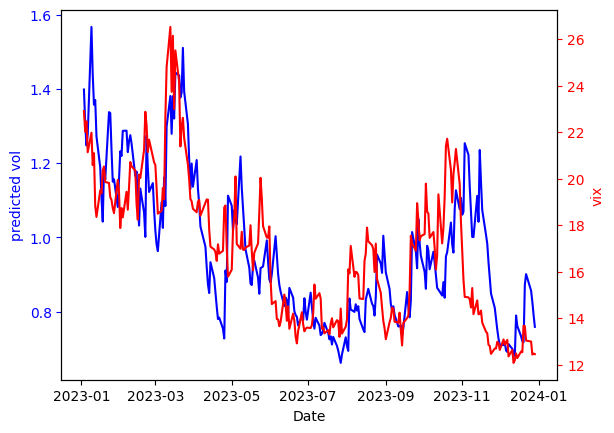

In [89]:
fig, ax1 = plt.subplots()
ax1.plot(pred_30day['vol'], color='blue', label='predicted vol')
ax1.set_xlabel('Date')
ax1.set_ylabel('predicted vol', color='blue')
ax1.tick_params('y', colors='blue')

# Creating a secondary axis
ax2 = ax1.twinx()
ax2.plot(vix_test['vix'], color='red', label='actual vix')
ax2.set_ylabel('vix', color='red')
ax2.tick_params('y', colors='red')

In [90]:
mu_30day = pred_30day.mean()
std_30day = pred_30day.std()

pred_30day_normalise = (pred_30day - mu_30day)/std_30day

In [91]:
mse_garch30day = mean_squared_error(pred_30day_normalise, vix_test_normalise)
r2_garch30day = r2_score(pred_30day_normalise, vix_test_normalise)
# binary_dt = np.sum((y_test_s * y_pred_dt) > 0)/ len(y_test_s)

print("Mean Squared Error of garch 30 day prediction:", mse_garch30day)
print("R-squared of garch 30 day prediction:", r2_garch30day)

Mean Squared Error of garch 30 day prediction: 0.49041488118560506
R-squared of garch 30 day prediction: 0.5076694356847632


In [92]:
garch_model = arch_model(sp_return.iloc[:start]['sp_return']*100, vol='GARCH', p=1, q=1)
# Fit the model
garch_results = garch_model.fit()

forecasts = garch_results.forecast(horizon=30)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1336056153.6687217
Iteration:      2,   Func. Count:     15,   Neg. LLF: 728254173.5174701
Iteration:      3,   Func. Count:     22,   Neg. LLF: 14358.756836164966
Iteration:      4,   Func. Count:     29,   Neg. LLF: 200517236.8490984
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10308.44899158063
Iteration:      6,   Func. Count:     42,   Neg. LLF: 10178.101467240496
Iteration:      7,   Func. Count:     48,   Neg. LLF: 10352.813767644624
Iteration:      8,   Func. Count:     54,   Neg. LLF: 10166.31776856733
Iteration:      9,   Func. Count:     59,   Neg. LLF: 10170.355337880448
Iteration:     10,   Func. Count:     65,   Neg. LLF: 10166.1165310139
Iteration:     11,   Func. Count:     70,   Neg. LLF: 10166.103509614893
Iteration:     12,   Func. Count:     75,   Neg. LLF: 10166.103455477361
Iteration:     13,   Func. Count:     80,   Neg. LLF: 10166.103453517178
Iteration:     14,   Func. Count:     84,   Neg. LLF: 101

## ARIMA forecast

In [93]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [94]:
vix_return = raw[['Date','vix_return']]
vix_return.set_index('Date', inplace=True)

In [95]:
start = len(vix_return.loc[:'2023-01-01'])
end = len(vix_return)

In [96]:
pred_arima = pd.DataFrame(index=vix_return.loc['2023-01-01':].index)
pred_arima['vix_return'] = 0

In [97]:
b = 0 
for a in range(start,end):
    order = (1, 1, 1)  # Replace this with the appropriate order for your data
    model = ARIMA(vix_return[:a], order=order)
    fit_model = model.fit()

    # Perform one-step ahead prediction on the test data
    predictions = fit_model.get_forecast(steps=1)
    predicted_mean = predictions.predicted_mean
    
    pred_arima['vix_return'][b] = predicted_mean
    
    b += 1

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates,

In [98]:
pred_arima

,vix_return
Date,
2023-01-03,-0.003571
2023-01-04,-0.007373
2023-01-05,0.000954
2023-01-06,-0.004393
2023-01-09,0.002945
...,...
2023-12-22,-0.002566
2023-12-26,0.001502
2023-12-27,-0.002438


In [99]:
vix = raw[['Date','vix']]
vix.set_index('Date', inplace=True)

In [100]:
len(vix.loc['2022-12-30':'2023-12-28'])

257

In [101]:
len(pred_arima)

257

In [102]:
# Resetting index for both DataFrames
pred_arima_reset = pred_arima.reset_index(drop=True) # starting 2023-01-03
vix_reset = vix.loc['2022-12-30':'2023-12-28'].reset_index(drop=True) # from 2022-12-30

In [103]:
merged_df = pd.merge(pred_arima_reset, vix_reset, left_index=True, right_index=True, how='left')

In [104]:
merged_df['vix_pred'] = merged_df['vix'] * (1 + merged_df['vix_return'])

In [105]:
merged_df['Date'] = raw[raw['Date']>= '2023-01-01']['Date'].reset_index(drop = True)

In [106]:
merged_df.set_index('Date', inplace=True)

In [107]:
raw[raw['Date'] == '2022-12-30']['vix']

7555    21.67
Name: vix, dtype: float64

In [108]:
merged_df

,vix_return,vix,vix_pred
Date,,,
2023-01-03,-0.003571,21.67,21.592623
2023-01-04,-0.007373,22.90,22.731157
2023-01-05,0.000954,22.01,22.030992
2023-01-06,-0.004393,22.46,22.361333
2023-01-09,0.002945,21.13,21.192226
...,...,...,...
2023-12-22,-0.002566,13.65,13.614975
2023-12-26,0.001502,13.03,13.049569
2023-12-27,-0.002438,12.99,12.958324


Text(0.5, 1.0, 'VIX Prediction using ARIMA 1,1,1')

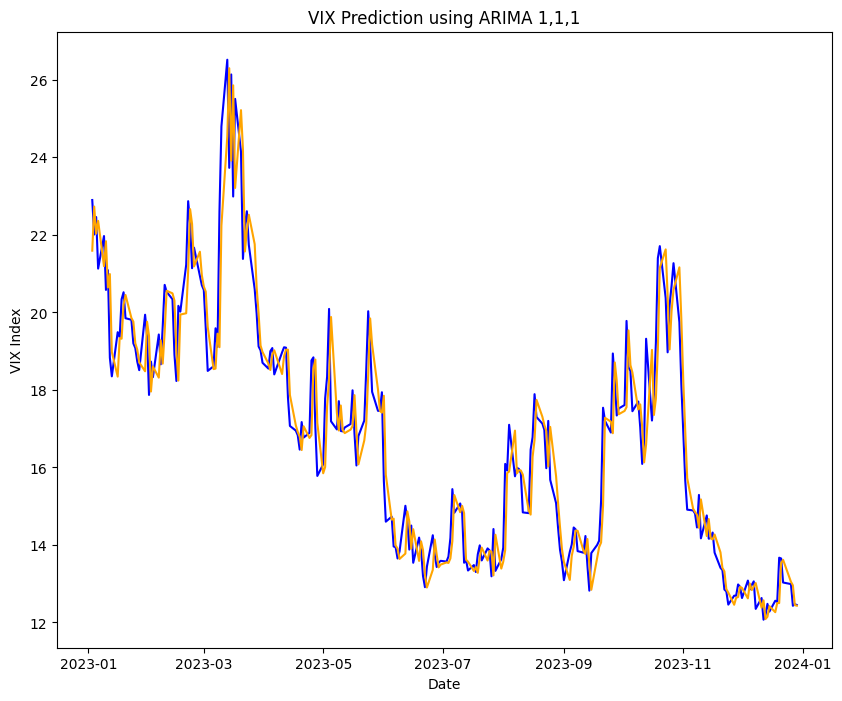

In [109]:
plt.figure(figsize=(10,8))
plt.plot(vix.loc['2023-01-01':], color = 'blue')
plt.plot(merged_df['vix_pred'], color = 'orange')

plt.xlabel('Date')
plt.ylabel('VIX Index')
plt.title('VIX Prediction using ARIMA 1,1,1')

In [110]:
mse_arima = mean_squared_error(pred_arima['vix_return'],vix_return.loc['2023-01-01':] )
r2_arima = r2_score(pred_arima['vix_return'], vix_return.loc['2023-01-01':])
binary_arima = np.sum((y_test_s * y_pred_dt) > 0)/ len(y_test_s)

print("Mean Squared Error of the ridge regression:", mse_dt)
print("R-squared of the ridge regression:", r2_dt)
print(f"Percentage of correct direction predicted is: {binary_dt}")

Mean Squared Error of the ridge regression: 0.007818294527397173
R-squared of the ridge regression: -1.1825853156565813
Percentage of correct direction predicted is: 0.49583333333333335


In [111]:
predicted_mean

7812   -0.003005
dtype: float64